In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.426013102412536473840491086280519425818/1-223.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.16568542011655175430071162144126831780/2-089.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.16568542011655175430071162144126831780/1-111.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.116437756113164247142539498550746659420/1-051.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.116437756113164247142539498550746659420/2-203.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.265953197912973660327069359641506533925/1-288.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.295670217913556255928452747763741622478/1-213.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.

In [21]:
!pip uninstall scikit-learn -y
!pip cache purge


Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Files removed: 6


In [22]:

!pip install scikit-learn --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 103.7 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [23]:
# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from matplotlib.image import imread

# Deep Learning
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, concatenate,
    BatchNormalization, Dropout, MaxPooling2D
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
import keras.utils as image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Oversampling
from imblearn.over_sampling import SMOTE

# Misc
import glob
import PIL
import random
random.seed(100)

# Confirm versions (optional debug)
print("TensorFlow version:", tf.__version__)
import sklearn
print("Scikit-learn version:", sklearn.__version__)


ImportError: cannot import name 'UnsetMetadataPassedError' from 'sklearn.exceptions' (/usr/local/lib/python3.11/dist-packages/sklearn/exceptions.py)

In [24]:
data_path = "/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/"

# Load CSV files
mass_train = pd.read_csv(data_path + "csv/mass_case_description_train_set.csv")
mass_test = pd.read_csv(data_path + "csv/mass_case_description_test_set.csv")
calc_train = pd.read_csv(data_path + "csv/calc_case_description_train_set.csv")
calc_test = pd.read_csv(data_path + "csv/calc_case_description_test_set.csv")
dicom_info = pd.read_csv(data_path +"/csv/dicom_info.csv")


def standardize_columns(df):
    df.columns = df.columns.str.replace(' ', '_')
    return df

mass_train = standardize_columns(mass_train)
mass_test = standardize_columns(mass_test)
calc_train = standardize_columns(calc_train)
calc_test = standardize_columns(calc_test)


# Label datasets and types
for df in [mass_train, mass_test]:
    df["type"] = "mass"
for df in [calc_train, calc_test]:
    df["type"] = "calc"

for df in [mass_train, calc_train]:
    df["dataset"] = "Train"
for df in [mass_test, calc_test]:
    df["dataset"] = "Test"
    
print("Mass train shape:", mass_train.shape)
print("Mass test shape:", mass_test.shape)
print("Calcification train shape:", calc_train.shape)
print("Calcification test shape:", calc_test.shape)

Mass train shape: (1318, 16)
Mass test shape: (378, 16)
Calcification train shape: (1546, 16)
Calcification test shape: (326, 16)


In [26]:
# Columns to drop
columns_to_drop = ["image_file_path", "cropped_image_file_path", "ROI_mask_file_path"]

# Drop the specified columns from each DataFrame
mass_train = mass_train.drop(columns=columns_to_drop, errors='ignore')
mass_test = mass_test.drop(columns=columns_to_drop, errors='ignore')
calc_train = calc_train.drop(columns=columns_to_drop, errors='ignore')
calc_test = calc_test.drop(columns=columns_to_drop, errors='ignore')

In [27]:
missing_image_path = dicom_info['image_path'].isnull().sum()
missing_patient_id = dicom_info['PatientID'].isnull().sum()

print(f"Missing values in 'image_path' column: {missing_image_path}")
print(f"Missing values in 'PatientID' column: {missing_patient_id}")

print(dicom_info.shape)

Missing values in 'image_path' column: 0
Missing values in 'PatientID' column: 0
(10237, 38)


In [28]:
import shutil
import os
#f A copy of the images has been made for avoiding any major changes in the actual file. 
# Source and destination paths
source_path = "/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg"
destination_path = "/kaggle/working/copied_jpeg"

# Copy the entire directory
if not os.path.exists(destination_path):
    shutil.copytree(source_path, destination_path)
    print(f"Copied all folders from {source_path} to {destination_path}")
else:
    print("Destination folder already exists. Skipping copy.")

Destination folder already exists. Skipping copy.


In [29]:
def clean_image_path(image_path):
    base_path = "/kaggle/working/copied_jpeg"
    return image_path.replace("CBIS-DDSM/jpeg", base_path)

dicom_info['image_path'] = dicom_info['image_path'].apply(clean_image_path)

# Extract and clean PatientID to 'P_XXXXX' format
def clean_patient_id(patient_id):
    if isinstance(patient_id, str) and "P_" in patient_id:
        patient_id_parts = patient_id.split("P_")
        if len(patient_id_parts) > 1:
            return f"P_{patient_id_parts[1][:5]}"  # Keep only the first 5 digits
    return patient_id

dicom_info['PatientID'] = dicom_info['PatientID'].apply(clean_patient_id)

# Save the cleaned dicom_info
dicom_info.to_csv("/kaggle/working/cleaned_dicom_info.csv", index=False)
print("Cleaning complete and saved as 'cleaned_dicom_info.csv'.")

Cleaning complete and saved as 'cleaned_dicom_info.csv'.


In [30]:
# Load the cleaned dicom_info.csv
cleaned_dicom_info = pd.read_csv("/kaggle/working/cleaned_dicom_info.csv")

# Ensure PatientID format is consistent in both train and test datasets
for df in [mass_train, mass_test, calc_train, calc_test]:
    df['patient_id'] = df['patient_id'].apply(clean_patient_id)
                                              
# Map the correct image_path from dicom_info
def map_correct_image_paths(df, dicom_info):
    # Create a mapping dictionary {PatientID: image_path}
    image_path_mapping = pd.Series(dicom_info.image_path.values, index=dicom_info.PatientID).to_dict()

    # Replace the 'image_path' in the dataframe using this mapping
    df['image_path'] = df['patient_id'].map(image_path_mapping)

    return df

# Apply image mapping to each dataset
mass_train = map_correct_image_paths(mass_train, dicom_info)
mass_test = map_correct_image_paths(mass_test, dicom_info)
calc_train = map_correct_image_paths(calc_train, dicom_info)
calc_test = map_correct_image_paths(calc_test, dicom_info)


# Check for missing images
for name, df in zip(["Mass Train", "Mass Test", "Calc Train", "Calc Test"],
                    [mass_train, mass_test, calc_train, calc_test]):
    print(f"Unmapped images in {name}: {df['image_path'].isnull().sum()}")

Unmapped images in Mass Train: 0
Unmapped images in Mass Test: 0
Unmapped images in Calc Train: 0
Unmapped images in Calc Test: 0


In [31]:
def save_with_validation(df, path):
    # Check if paths exist before saving
    valid = df['image_path'].apply(lambda x: isinstance(x, str) and os.path.exists(x))
    print(f"Valid paths in {path}: {valid.sum()}/{len(df)}")
    
    # Save only if paths are valid
    if valid.all():  # Ensure all paths are valid
        df.to_csv(path, index=False)
        print(f"Data saved successfully to {path}.")
    else:
        print(f"Some image paths are invalid. Data was not saved to {path}.")

# Save datasets with validation
save_with_validation(mass_train, "/kaggle/working/mass_train_with_images.csv")
save_with_validation(mass_test, "/kaggle/working/mass_test_with_images.csv")
save_with_validation(calc_train, "/kaggle/working/calc_train_with_images.csv")
save_with_validation(calc_test, "/kaggle/working/calc_test_with_images.csv")

Valid paths in /kaggle/working/mass_train_with_images.csv: 387/1318
Some image paths are invalid. Data was not saved to /kaggle/working/mass_train_with_images.csv.
Valid paths in /kaggle/working/mass_test_with_images.csv: 103/378
Some image paths are invalid. Data was not saved to /kaggle/working/mass_test_with_images.csv.
Valid paths in /kaggle/working/calc_train_with_images.csv: 455/1546
Some image paths are invalid. Data was not saved to /kaggle/working/calc_train_with_images.csv.
Valid paths in /kaggle/working/calc_test_with_images.csv: 89/326
Some image paths are invalid. Data was not saved to /kaggle/working/calc_test_with_images.csv.


In [32]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

def is_binary_mask(image_path, threshold=10, ratio_threshold=0.98):
    """
    Check if an image is a binary mask with values close to 0 and 255.
    
    Args:
        image_path: Path to the image file
        threshold: Allowed variation from pure black/white (default: ±10)
        ratio_threshold: Minimum fraction of pixels that must be near 0 or 255
                         to be considered binary (default: 98%)
    """
    try:
        img = Image.open(image_path).convert("L")  # Convert to grayscale
        pixels = np.array(img)
        
        # Calculate how many pixels are near 0 or near 255
        near_black = np.sum((pixels >= 0) & (pixels <= threshold))
        near_white = np.sum((pixels >= 255 - threshold) & (pixels <= 255))
        total_pixels = pixels.size
        
        # Calculate the ratio of pixels that are near black or white
        binary_ratio = (near_black + near_white) / total_pixels
        
        return binary_ratio >= ratio_threshold
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return False

# Directory containing the images
source_dir = "/kaggle/working/copied_jpeg"

# Walk through all image files in the directory
image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}
removed_count = 0

for root, dirs, files in tqdm(os.walk(source_dir), desc="Filtering images"):
    for file in files:
        file_lower = file.lower()
        if any(file_lower.endswith(ext) for ext in image_extensions):
            src_path = os.path.join(root, file)

            if is_binary_mask(src_path):
                try:
                    os.remove(src_path)
                    removed_count += 1
                    print(f"Removed binary mask: {src_path}")
                except Exception as e:
                    print(f"Failed to remove {src_path}: {e}")

print(f"Removed {removed_count} binary mask images from {source_dir}.")

Filtering images: 2it [00:00, 13.76it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.426699529512528481528182485951057622249/2-065.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.292889964913238503531512713221818158737/2-044.jpg


Filtering images: 4it [00:00,  9.59it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.365251304312696425116097967672745760532/2-171.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.154606233111503439929685620743841618724/2-023.jpg


Filtering images: 10it [00:01,  9.29it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.345522512011144937217670143263509609355/2-201.jpg


Filtering images: 12it [00:01,  8.21it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.163647357511753297033099610980022844957/2-000.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.67204285013759616112542232592030592136/2-145.jpg


Filtering images: 16it [00:01,  8.42it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.111914723211477946202547603321613023085/2-043.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.242688627112395349124555043112721835015/2-057.jpg


Filtering images: 24it [00:02, 10.26it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.324551556111223663025351205692776613584/2-253.jpg


Filtering images: 28it [00:02, 10.08it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.94022745112775314306588417851708070986/1-167.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.206688139012341920023860970853295898069/2-179.jpg


Filtering images: 30it [00:03, 10.02it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.64900583912400133201398296532125171360/2-152.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.151168597710103342317296629052967050185/2-049.jpg


Filtering images: 32it [00:03, 10.31it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.367238557012890560621804356401806515269/2-107.jpg


Filtering images: 37it [00:04,  8.01it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.340884794411477928114682894642675747391/2-269.jpg


Filtering images: 38it [00:04,  8.17it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.263962073213889344204212412241773647126/2-225.jpg


Filtering images: 43it [00:04,  8.90it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.200316094012726625315753842373051904056/2-265.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.47759147212856924416963526780900223664/2-179.jpg


Filtering images: 45it [00:05,  7.49it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.96546303311392502812038476020092775157/2-185.jpg


Filtering images: 47it [00:05,  8.30it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.16457223513449463205837326340477726730/2-120.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.398318437511620610227483296150125763576/2-180.jpg


Filtering images: 50it [00:05,  9.55it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.87747304813106768832465470981961783228/2-178.jpg


Filtering images: 54it [00:05,  9.94it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.264360226812502591412468604320964315435/2-149.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.94901026311616840612263927290971997989/1-228.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.331490273111274524529332883292939835684/2-025.jpg


Filtering images: 56it [00:06,  8.89it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.427999667712091339220453446920156471922/2-192.jpg


Filtering images: 57it [00:06,  8.56it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.350227954211369092108161914102275089523/2-083.jpg


Filtering images: 60it [00:06,  8.67it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.359651853712808948841056639084050736630/2-094.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.118966753911907096715576455013051361981/2-187.jpg


Filtering images: 64it [00:07,  8.09it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.384199802212192718828742347882671731615/2-158.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.132704822212018315107629515583508000817/2-289.jpg


Filtering images: 67it [00:07,  9.65it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.66341513511912530900141861650067004652/2-297.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.364106180611135714608055515470826120133/2-070.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.335520944312321077400253584883682866572/1-075.jpg


Filtering images: 71it [00:07,  8.90it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.230171348413918905101815148832638505428/2-093.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.80886674312817201836626612943776301160/2-210.jpg


Filtering images: 73it [00:08, 10.50it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.321456020512188215330994917754090294666/1-069.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.309137596311103924008154031644268606037/2-079.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.387306537011339133438721606914081037725/2-156.jpg


Filtering images: 77it [00:08,  8.78it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.244268262412250517910105591184063699649/2-235.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.24413910212876553434565096140956898495/2-037.jpg


Filtering images: 82it [00:08, 12.35it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.413281056012448750609869024412386754653/2-076.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.131605236213602979841291004172384872136/2-239.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.417009583312382634503537924402100480108/1-239.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.415155561811480647441228154010370505874/2-246.jpg


Filtering images: 86it [00:09, 14.93it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.406851690713929110036335307660919142685/2-060.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.387700463213120394609522256952697830975/2-224.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.230234848611578484115488520973412824309/2-246.jpg


Filtering images: 90it [00:09, 12.63it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.134542862513183881627796686502056036103/2-141.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.32729783411587380541116571070634396726/2-066.jpg


Filtering images: 92it [00:09, 10.95it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.157157547910819001637226899553623210917/2-071.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.265798879911823601104886739321580467703/2-237.jpg


Filtering images: 94it [00:09,  9.85it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.7394325412419055524300338092172956526/2-194.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.417471070612455676804837060152413123968/2-065.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.387934895113475486427172740453619326868/2-225.jpg


Filtering images: 102it [00:10, 12.88it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.85952808612741483701251063181906874633/2-271.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.209613585310883940908822644801525937529/2-139.jpg


Filtering images: 104it [00:10, 12.23it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.201549062912216391734259759412337319975/2-072.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.244876997513875090239564803900035037851/2-099.jpg


Filtering images: 112it [00:11, 14.15it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.92306183113245123207005034350940892013/1-080.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.92463197811958955940268497132832001393/2-264.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.188222738012645119031842976551461534440/2-125.jpg


Filtering images: 114it [00:11, 14.12it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.91670540912661849412776480483933682638/2-191.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.343948967311982029004989313710355633688/1-078.jpg


Filtering images: 118it [00:11, 11.50it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.157303470811153697510553713941802242843/2-256.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.148510782411892969000328334682847063989/2-193.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.133462910711791086431220023163537511246/1-083.jpg


Filtering images: 122it [00:12, 12.03it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.213052676211719173330660601650388913349/1-196.jpg


Filtering images: 124it [00:12, 10.37it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.67632872612701025609994152223974707528/2-144.jpg


Filtering images: 126it [00:12, 11.69it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.95827779212255247438183443413984592392/2-127.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.201522562711496443720752570002776479535/1-110.jpg


Filtering images: 130it [00:13, 10.27it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.151259729913947580902963565433723891335/1-188.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.151809261912849437430594088173996846400/1-293.jpg


Filtering images: 134it [00:13, 11.34it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.296281207812130400303493285473798422894/2-108.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.18139311113797409607542071671201455080/2-093.jpg


Filtering images: 136it [00:13, 11.15it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.354447778710312542110033340782411712017/2-277.jpg


Filtering images: 140it [00:13, 10.94it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.284402166210743654813583379650458642794/2-074.jpg


Filtering images: 142it [00:14, 10.36it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.213373259211561590636126913501301096523/1-250.jpg


Filtering images: 146it [00:14, 10.10it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.366441649213826529828811232162877765642/2-008.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.108313428911260011810301275420237893771/1-021.jpg


Filtering images: 148it [00:14, 10.05it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.346025937412185970623503494401058404347/2-216.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.381187369611524586537789902641525311317/2-204.jpg


Filtering images: 152it [00:14, 12.67it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.161165022611012228441146507963185372207/2-136.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.25808746612056028922655832353262270502/2-292.jpg


Filtering images: 156it [00:15, 10.26it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.66138878112869257633340138833581720607/2-287.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.209697303710902279801410290493638607923/1-221.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.298648398112853530923210871563609947010/2-196.jpg


Filtering images: 162it [00:16, 10.98it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.245372915412732365802560506200352567308/2-098.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.195128105212967051304365067870504250028/2-175.jpg


Filtering images: 164it [00:16, 10.00it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.359349045811000526528033819352723885958/2-050.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.391555792511051783100838378621839291058/2-269.jpg


Filtering images: 166it [00:16,  9.81it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.242879520313036652404133300552605167567/1-103.jpg


Filtering images: 175it [00:17, 10.47it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.215883384511109118824190798611322360452/1-159.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.71622403711125508028350841743449446664/2-063.jpg


Filtering images: 179it [00:17, 13.23it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.287972075310796878035981879220214782547/2-059.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.405418520913113377021793824510072876557/2-183.jpg


Filtering images: 181it [00:17, 12.74it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.137898033612101518602840511311691134958/1-160.jpg


Filtering images: 183it [00:18, 10.04it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.331024935512250669734264199000795133151/2-168.jpg


Filtering images: 185it [00:18,  9.35it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.79499652111949049823553709274093131525/1-291.jpg


Filtering images: 191it [00:19,  9.18it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.170505828913090794017590268212890536553/2-061.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.166811186713026003422384920873357262329/2-276.jpg


Filtering images: 194it [00:19,  8.72it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.368004662912542721327992859391849058162/2-093.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.161215703310404454342793885940416717304/1-207.jpg


Filtering images: 196it [00:19,  9.90it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.417648191012923677524976239580596100929/1-251.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.237223252511742491419232357641797761600/2-222.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.329748907011080227609149103793436938722/2-159.jpg


Filtering images: 200it [00:20,  9.34it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.113834944313152995040006434701854474909/2-290.jpg


Filtering images: 204it [00:20, 10.52it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.263175968212620451040123544731301212892/2-028.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.378705197111746356616770236343226660091/2-027.jpg


Filtering images: 206it [00:20, 10.55it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.384199099313163908141123265622992905145/2-225.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.147697216711708235030279341274063271893/2-088.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.348437209511819882819177566002998394324/2-196.jpg


Filtering images: 210it [00:21,  9.44it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.233956377611541061703882187721164203058/1-143.jpg


Filtering images: 212it [00:21,  9.27it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.408969321410699205918013687111110159762/2-184.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.265940018312225650840966056303616150848/1-191.jpg


Filtering images: 214it [00:21,  9.39it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.270964980412538159307361770414010109388/1-175.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.69927559813999999622780645272240176900/2-082.jpg


Filtering images: 220it [00:21, 13.62it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.343415346312123544113551650783871288016/1-284.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.375021222710386537204756102772683691129/1-008.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.311132814312615054403783067432154879476/2-208.jpg


Filtering images: 222it [00:22, 11.04it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.374142001110349203339388573802663391669/2-020.jpg


Filtering images: 226it [00:22,  8.82it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.291124250412889525331702012203770510820/2-157.jpg


Filtering images: 230it [00:22, 10.76it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.93044142711470198221610924971131123885/2-276.jpg


Filtering images: 232it [00:23,  9.00it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.122370731312059877842058766350947453827/2-028.jpg


Filtering images: 238it [00:23, 10.61it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.154781705113775608900067454770325217687/2-161.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.409108935412704052237905575740458551281/2-053.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.34719084810338030929028689201743802900/1-175.jpg


Filtering images: 242it [00:24, 11.06it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.40455975913588125708995424281954409099/2-057.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.159695142810722496522456887154045338408/2-125.jpg


Filtering images: 244it [00:24,  9.30it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.307374649711829059242586438551305692016/2-239.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.49659321812549392635504797472061503604/2-180.jpg


Filtering images: 253it [00:25, 12.17it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.294502521311914830642172663623958151512/2-111.jpg


Filtering images: 255it [00:25, 10.14it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.173098323712499988837409437962712304857/1-243.jpg


Filtering images: 259it [00:25, 10.83it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.175949418811470559032138812202168772020/2-001.jpg


Filtering images: 261it [00:26,  9.35it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.387703886612196514302739624273382071518/2-180.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.272989302011440004640576680082276087338/2-139.jpg


Filtering images: 263it [00:26,  8.64it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.362202919811014156001059439622568248574/2-143.jpg


Filtering images: 266it [00:26,  8.32it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.302882614412603902327039591953465565137/1-282.jpg


Filtering images: 271it [00:27,  8.18it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.204370117111774428836779038073111328965/2-145.jpg


Filtering images: 277it [00:28, 10.49it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.58322137412485391810382982722027426694/2-162.jpg


Filtering images: 281it [00:28, 11.37it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.177843840912535244135838045551599621094/2-225.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.332455545813144972524917318463183840675/2-035.jpg


Filtering images: 284it [00:28,  8.64it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.412653122812039951642173610801217192136/2-167.jpg


Filtering images: 288it [00:29, 10.87it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.129406041612334423603149103982541993290/2-272.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.299479312912648479419761596652152845359/2-203.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.268291743011528218403844110273625927135/2-297.jpg


Filtering images: 294it [00:29, 14.22it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.62110245013308339630284755483859171619/2-007.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.327802325011574904120839671651989730373/1-278.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.68108819512864468427526491393839092360/2-009.jpg


Filtering images: 296it [00:29, 11.84it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.256403565813600307536474945580729509681/2-181.jpg


Filtering images: 300it [00:29, 13.28it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.101245645112886250614071592174163863244/2-177.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.399922507013829701925779260691918475374/2-257.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.325008952211176049115228258572880805694/2-217.jpg


Filtering images: 304it [00:30, 11.04it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.306231427610466354735096101303712317796/2-013.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.167551388612176433614880821111626540662/2-198.jpg


Filtering images: 312it [00:31,  8.23it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.136344262911883698420646440030074567918/2-159.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.299416691811132387805047574290099100208/2-070.jpg


Filtering images: 314it [00:31,  9.64it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.139037726311126705616528180693822199789/2-250.jpg


Filtering images: 317it [00:31,  9.01it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.313742823411562430408347460331482749149/2-077.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.146067391511184368515298581922159428804/2-146.jpg


Filtering images: 320it [00:32, 11.04it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.205317405612110754934227649302172690795/2-064.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.194212286711399374733074771812507083267/2-282.jpg


Filtering images: 322it [00:32, 10.22it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.232655664111867764900916015764258363014/2-226.jpg


Filtering images: 325it [00:32,  8.87it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.11155369213340314107640854320227057414/2-197.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.163204050313051539510357761620904552624/2-196.jpg


Filtering images: 328it [00:33,  9.69it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.415945278010571172614725973761171003724/2-190.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.200712718712154870111814811021509174333/2-229.jpg


Filtering images: 334it [00:33,  9.85it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.250462778711222869426452230721254407820/2-277.jpg


Filtering images: 338it [00:33, 12.85it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.245633900110007082034118990512969470333/1-137.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.266407746911029259038188299753927009234/2-166.jpg


Filtering images: 340it [00:34, 12.39it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.19665754512295252425426031390768754621/1-182.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.194049371012376262322141457090192676444/1-083.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.74426009913010551139890152232809554081/1-030.jpg


Filtering images: 344it [00:34, 12.30it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.112537751311130539116707368250660143815/2-013.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.410370698810299290327246936840562577791/2-111.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.46792895212991810221677541571410025425/2-100.jpg


Filtering images: 348it [00:34, 11.54it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.281340146110857934414592536624150012224/2-056.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.237754682912206823705336615711139959202/2-116.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.386287721313765271638567033852357863555/1-182.jpg


Filtering images: 354it [00:35, 14.45it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.195179858111028235532847886713406759186/2-208.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.35213499610180117017197818161597828685/2-097.jpg


Filtering images: 356it [00:35, 12.59it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.42069765413321717222763216890129326500/2-081.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.419081637812053404913157930753972718515/2-097.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.168652704811565866529672651651995693709/1-285.jpg


Filtering images: 358it [00:35, 11.47it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.243328526311486984206651759443117883160/2-130.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.188073839111134406940439343533691604080/2-038.jpg


Filtering images: 366it [00:36, 10.92it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.4524778711222068800737640201707743363/2-167.jpg


Filtering images: 368it [00:36, 11.61it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.238643079911460150420430179133578288772/2-005.jpg


Filtering images: 372it [00:36, 10.70it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.308402021611338103228361317470352720087/2-133.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.146461053511092252329004980923015248368/2-022.jpg


Filtering images: 374it [00:36, 11.93it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.335479646812762679101737627170413443119/2-096.jpg


Filtering images: 382it [00:37, 13.01it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.12508028112325059806311681360463519666/2-147.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.3866969912785618842192247560363093126/2-136.jpg


Filtering images: 384it [00:37, 12.38it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.280285174113278235527658797191016317873/2-075.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.193596412512123752718353896074113724101/1-296.jpg


Filtering images: 388it [00:38, 12.27it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.186156678811314368526525210882363095949/2-044.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.190187409513679913613795411490913454467/2-159.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.232015616011940511429471107840008891072/2-191.jpg


Filtering images: 390it [00:38, 11.87it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.411966477213014359701383742861949912247/2-124.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.925408612186932827878432183438732122/2-107.jpg


Filtering images: 392it [00:38, 12.46it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.124924551112234117927115122171466975954/2-282.jpg


Filtering images: 394it [00:38, 11.16it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.62879353212924234910426659083390529775/2-140.jpg


Filtering images: 398it [00:39,  8.47it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.424325096511908521711852484042496710975/2-170.jpg


Filtering images: 402it [00:39,  9.42it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.147223692311965288200325710140215692967/2-134.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.181197985512640766223906228531527667693/1-293.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.261038958613341762712247433262593053162/1-140.jpg


Filtering images: 404it [00:39,  9.20it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.111234686411972432106619516282806676862/1-157.jpg


Filtering images: 407it [00:40,  7.71it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.47830725612575729903732384520660902538/2-238.jpg


Filtering images: 411it [00:40,  7.45it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.356100158511456610542036010743669051391/2-013.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.312046195711877682033568111621028552592/2-141.jpg


Filtering images: 413it [00:41,  8.48it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.157526471413013958018158104822565522677/1-272.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.80043732812738825434038752291232759448/2-058.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.319515427413743533916869065043416336157/2-097.jpg


Filtering images: 419it [00:41, 11.18it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.331814373612720676514263148990617553605/2-090.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.10658885911501181010386825340527343068/2-118.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.267981811711236059342449074454242366571/2-085.jpg


Filtering images: 423it [00:41, 13.20it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.317537345412573702942126481161897405621/2-224.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.72010840811647743625324599213606476079/2-096.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.51430502013745545513583497012677475080/2-123.jpg


Filtering images: 425it [00:42, 11.40it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.68530981111298511433726816353081765969/2-183.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.84495138812036775930101272800359498306/1-022.jpg


Filtering images: 427it [00:42, 11.37it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.190185313111567002412779898101290641955/2-209.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.83185087113360879836206481171266877642/2-134.jpg


Filtering images: 429it [00:42, 11.18it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.265708461310696308514982120193169816782/2-175.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.274788580013716070231595242741859288638/2-290.jpg


Filtering images: 435it [00:43,  9.33it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.214678038712807936316129340732249794480/2-199.jpg


Filtering images: 439it [00:43,  9.97it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.210604569211177131520271008481012270185/1-102.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.291708845612396087500547083711670299943/2-168.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.12469869212537514230750514072705425364/1-120.jpg


Filtering images: 447it [00:44, 10.85it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.243973104911020942327740141343962897455/1-181.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.14064028811800401439367322990347421397/2-120.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.417257767913248192623265844502388719229/2-072.jpg


Filtering images: 449it [00:44, 10.60it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.341573340913913266113502488781486646386/2-109.jpg


Filtering images: 451it [00:44, 10.00it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.389273289611161275802317999421109002390/2-132.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.182941720511336330741717526001222687904/1-126.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.59946788013216870726047456320017500210/2-073.jpg


Filtering images: 457it [00:45,  9.40it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.109452252012424458222829590173400022787/2-081.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.268369853012040747917775940281850188685/2-166.jpg


Filtering images: 461it [00:45, 12.66it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.184416677410740051905957034634253020399/2-213.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.262644777912480313102547818790144949196/2-131.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.62431698612852928124272298264114698763/2-067.jpg


Filtering images: 463it [00:45,  9.99it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.355021781011678796714787035023343987487/2-123.jpg


Filtering images: 468it [00:46,  9.08it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.86622033913828703533750660040467085652/2-258.jpg


Filtering images: 474it [00:47, 11.08it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.303083829613490279630452343061677788640/2-024.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.225841479311276787019923367781330783197/2-018.jpg


Filtering images: 476it [00:47, 11.67it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.327038166513047797405327674041149707420/2-047.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.404654255612590080309146884192084552510/1-070.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.382610572212375066312260561031651158085/2-190.jpg


Filtering images: 482it [00:47, 13.73it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.245720477912785929822325797282302327687/2-163.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.12556992411326765521017138092956730375/2-102.jpg


Filtering images: 486it [00:48, 11.65it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.46822605611553764431555831582808498077/2-170.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.220410324912644123414578395360948739450/2-086.jpg


Filtering images: 490it [00:48, 11.03it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.78953662012289228020056948630934822284/2-237.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.355734454812919346710853418312364204403/2-178.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.178641786510785037927937898552963541072/2-224.jpg


Filtering images: 492it [00:48, 11.49it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.406124346911419317213489606964022388284/1-161.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.213923189612009468827338377582033345163/2-176.jpg


Filtering images: 496it [00:48, 11.88it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.83278964612407383507170994380094259682/1-280.jpg


Filtering images: 498it [00:49, 10.57it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.353296670212136564600776045344219492366/2-142.jpg


Filtering images: 502it [00:49, 12.61it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.29026422512550798242134647590421996608/2-153.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.175886582313568715400708524902994803805/2-071.jpg


Filtering images: 506it [00:49,  9.75it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.120975940711859679428672273083840976036/2-131.jpg


Filtering images: 514it [00:50, 10.06it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.300168913010010531122616152880919563274/2-064.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.295670217913556255928452747763741622478/2-129.jpg


Filtering images: 518it [00:51,  9.31it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.248660790613687800537285595443836903846/2-170.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.120136387411151021442495737882781334225/1-202.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.328011571912253968128627544932881689288/2-084.jpg


Filtering images: 520it [00:51,  9.61it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.266246026213267261740525272940484177978/2-184.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.357214585012696579228748059281324511668/2-072.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.123416486011669671703336603090186149396/2-195.jpg


Filtering images: 524it [00:51, 10.62it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.16797291711280675438259327020908841485/2-205.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.123284977813439199229313409760801151925/2-212.jpg


Filtering images: 526it [00:51, 11.70it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.284464123012025065005317272673765215147/2-035.jpg


Filtering images: 528it [00:52,  9.98it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.172249911913244794903312682790354887670/1-266.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.122021886313853636738943991213171853079/2-015.jpg


Filtering images: 532it [00:52,  9.75it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.101916619211998977734958230192374913578/2-052.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.225365782410908702836318240563318372418/2-014.jpg


Filtering images: 540it [00:53, 11.05it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.315743475411279675824136470271131835683/2-203.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.154302711013801535939460074850736831453/2-198.jpg


Filtering images: 542it [00:53, 10.33it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.68264675712058421305739306243126509346/2-086.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.391195498012104141006460448243492391195/2-221.jpg


Filtering images: 544it [00:53, 10.82it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.336515370512454696731372561201993540774/2-052.jpg


Filtering images: 548it [00:54, 10.33it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.295633062913757524832888662093806859344/2-169.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.183782728513515522926100092742523453489/2-087.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.68212116710493161835358532393824099886/2-264.jpg


Filtering images: 552it [00:54,  9.56it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.98617005612136042927329867742505896570/1-144.jpg


Filtering images: 555it [00:54, 11.38it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.59807174411461248123448447121065500011/1-183.jpg


Filtering images: 557it [00:55, 10.71it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.209605321012748626627455520162879888688/2-263.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.395498135313441187838512866790242299270/2-223.jpg


Filtering images: 561it [00:55,  9.35it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.157378302511839517709372453321374326414/2-137.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.113558418111732268637097532660568705115/2-019.jpg


Filtering images: 563it [00:55, 10.27it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.164558435113571350334299352514278183109/2-170.jpg


Filtering images: 565it [00:55, 10.63it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.364927700011315459741075498511673465715/2-093.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.80724077612045866442150626872627771405/2-245.jpg


Filtering images: 574it [00:56, 11.13it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.399993571112105330626066251803693650709/2-276.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.354393322011557367835928690122016618367/1-060.jpg


Filtering images: 576it [00:56, 11.16it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.373013323512454361820543277183071337434/2-178.jpg


Filtering images: 578it [00:57,  9.72it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.311313415912769148235686849460609112304/1-038.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.319772607612291177008295115832242706231/2-234.jpg


Filtering images: 582it [00:57, 10.09it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.3292207611184459911687632993709630163/2-156.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.188687509410618341802747273162629893320/2-213.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.229884593710867275129805277951021683949/2-077.jpg


Filtering images: 586it [00:57, 10.71it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.206145355811078882713373016464279817059/2-098.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.117041576511324414842508325652101471266/1-247.jpg


Filtering images: 588it [00:58,  9.67it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.210100596611247116939368565003551688137/2-182.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.13336782711050907714720825861552685063/1-215.jpg


Filtering images: 590it [00:58,  9.93it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.302623090512798498106457675911463356258/2-148.jpg


Filtering images: 592it [00:58,  9.78it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.80152416612713350235932476272052967746/2-202.jpg


Filtering images: 596it [00:59, 10.63it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.257893743713458623316532156524247009552/2-134.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.388636067512527636836953061311268483123/1-154.jpg


Filtering images: 600it [00:59, 12.00it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.40629582313887326118580579092807259508/2-007.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.219155182110475447623755959603632750640/1-159.jpg


Filtering images: 602it [00:59, 10.78it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.217251302612401701737828896573116741101/2-101.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.358637202612132265739909999922066344965/2-100.jpg


Filtering images: 606it [01:00,  9.14it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.96085149011653638841617314732671061337/2-171.jpg


Filtering images: 610it [01:00,  9.53it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.248562395712535703004722180191382728112/1-185.jpg


Filtering images: 612it [01:00, 10.07it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.295776251011226874610717188340282977766/2-202.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.36259365311741726020089002403114757577/2-047.jpg


Filtering images: 614it [01:00,  9.86it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.380616930711845654525930515792575143339/1-020.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.284362639110554815311387790471173445496/2-249.jpg


Filtering images: 616it [01:01,  9.57it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.86954155211283956904941408321117693439/2-188.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.247344306013953089135970481920086034660/2-076.jpg


Filtering images: 620it [01:01, 10.99it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.22011950713133475930291969510689163306/2-026.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.154220000811470136627645428572220749721/2-178.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.347224591512122870537565272620441354495/2-207.jpg


Filtering images: 624it [01:01, 10.04it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.59452203312602182905976990031311831670/2-147.jpg


Filtering images: 627it [01:02,  9.49it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.154459962812255568331162059933876295818/2-156.jpg


Filtering images: 630it [01:02, 10.22it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.120504356811852312511652975492930678383/2-057.jpg


Filtering images: 636it [01:03,  8.71it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.297942702113156678811338459062814110038/2-053.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.95576229211857968242934102022883289746/2-032.jpg


Filtering images: 638it [01:03, 10.15it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.106588546212208683524717162253577510837/1-096.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.219786085412672570526863064791404952375/2-025.jpg


Filtering images: 642it [01:03,  9.83it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.53170057110704206316749464354093307618/1-279.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.376857136511728496304725815232254852162/2-204.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.339741705210596169125722241780551230987/2-258.jpg


Filtering images: 646it [01:04, 10.23it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.108998325811479398607974727033630566895/2-027.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.167540682913452382412575914360915363480/2-248.jpg


Filtering images: 648it [01:04, 11.20it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.302742531412890276818518362983960624431/2-021.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.291343565612604016624076538230434068368/2-207.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.142313024210626909616380200202083720554/1-268.jpg


Filtering images: 655it [01:04, 11.44it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.298549745011676405830269444460472128917/2-253.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.84857614811208960942130353953345115139/2-196.jpg


Filtering images: 659it [01:05, 12.28it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.245646912813583051808181364562111280814/2-125.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.260041375911514672736486258143818331864/2-086.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.130923372212143927441859057970923281238/2-035.jpg


Filtering images: 661it [01:05, 12.40it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.106469713711967596836488505611802834185/1-264.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.314482593211447105225663929790106186423/2-176.jpg


Filtering images: 669it [01:06, 11.44it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.299844048712116315321281215043759859662/2-081.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.191346184611579246705327681511862370492/2-233.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.167612513812352577506256994842185282809/1-060.jpg


Filtering images: 673it [01:06, 11.61it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.150654571513575380414867902870430875056/2-056.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.310354580112648215506863264034185988534/2-184.jpg


Filtering images: 675it [01:06, 11.09it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.255342706011950247106132187122478295455/2-028.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.39954840610186538831952129672702671745/2-210.jpg


Filtering images: 681it [01:07, 12.13it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.315403577811049297229677036841030881379/2-174.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.118656851512588862640074287501450248226/2-139.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.3707170310756826234724890924094328172/1-040.jpg


Filtering images: 685it [01:07, 12.13it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.111562224211759974529497376102449422156/2-066.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.248311662610507637216981226523146673321/2-144.jpg


Filtering images: 689it [01:07, 11.80it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.406939296510585519726018582372408965846/2-243.jpg


Filtering images: 693it [01:08, 11.39it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.253577647211486288738345440633391183201/2-011.jpg


Filtering images: 695it [01:08, 11.20it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.228511625213025378401837270111814860184/2-151.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.410056914911177315136773523261703761585/2-112.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.421121319413589213923871358761712534619/2-273.jpg


Filtering images: 697it [01:08, 11.79it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.180543280212805752911542749453500815790/2-162.jpg


Filtering images: 703it [01:09, 13.28it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.375830253112899228738641160991069708034/2-263.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.39603669310727873713809627273528862680/1-283.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.282589057612957708106733336421961502025/1-033.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.173942083512610747039850599731679712369/2-261.jpg


Filtering images: 709it [01:09, 12.23it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.298995667813572866526342340062137550931/2-178.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.128711204912650476337841768293732483222/2-195.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.318685678213200406618720861631644805060/2-276.jpg


Filtering images: 711it [01:09, 10.72it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.71814450612723278017223476651756211366/2-293.jpg


Filtering images: 713it [01:10, 11.21it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.198413694912048505722657583393402072629/2-168.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.255265052313494697218284752823751287734/2-079.jpg


Filtering images: 715it [01:10, 10.07it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.153103568711712377022447999032380454652/2-211.jpg


Filtering images: 717it [01:10,  9.78it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.210459296913189622509341746553908565694/2-136.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.6073290111128072308762159373187537346/2-233.jpg


Filtering images: 722it [01:11,  9.50it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.232688639712674011711814437233072194082/2-206.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.199001970610477911423051022612085370950/2-262.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.386415983311767559930907593141387085597/2-210.jpg


Filtering images: 731it [01:12, 10.18it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.21333574013081911514151041870468308024/2-292.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.370047058411160509216337197304234192394/2-165.jpg


Filtering images: 735it [01:12, 12.79it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.29874535413588066822824838883550729379/1-268.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.304117436612949689637956561203603784399/2-151.jpg


Filtering images: 739it [01:12, 12.75it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.87281653211161359928806357830281174497/2-274.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.424889390711092892018162257160068574314/2-204.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.10220758511115978206909776823706616403/1-085.jpg


Filtering images: 741it [01:12, 11.49it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.158293068310005551203360188610273740117/2-061.jpg


Filtering images: 743it [01:13, 10.39it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.370921180210043705603169978151721171292/2-010.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.54984100111963561607042712801943493016/2-292.jpg


Filtering images: 747it [01:13, 11.13it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.213726132413939031734618144110675908057/2-085.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.22606113111139075832646235213176574515/2-035.jpg


Filtering images: 753it [01:14, 10.06it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.176147061012109716001735110700691714998/1-136.jpg


Filtering images: 759it [01:14, 10.22it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.72213555810555994625280390951373929440/2-226.jpg


Filtering images: 761it [01:14, 10.86it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.99354895211596040721595987811380180183/2-184.jpg


Filtering images: 763it [01:15,  9.69it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.210700650311256118023753675981671833149/2-041.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.263710515111430117636886025211544850384/2-299.jpg


Filtering images: 767it [01:15, 10.12it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.149976076611593929425964018540102398535/2-054.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.193217889712403095817239095663161018262/2-189.jpg


Filtering images: 771it [01:15, 11.27it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.423499231212881160204769583761108492727/1-288.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.253002196012708182229226385020612041972/1-185.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.116437756113164247142539498550746659420/2-203.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.312092844012721105907883703442647490264/1-253.jpg


Filtering images: 773it [01:15, 12.84it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.423486274513149331225937273782817255738/2-225.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.401103076411422365839738925242183339717/2-169.jpg


Filtering images: 775it [01:16, 10.95it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.251098045911979762921708304802076525274/2-084.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.316298261312019251424151835271692075228/2-241.jpg


Filtering images: 779it [01:16,  9.22it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.401989378412840816927174898314104512220/2-083.jpg


Filtering images: 783it [01:17,  9.70it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.296383512311068971129322080220007118072/2-142.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.114073417612127118730790803803725889935/2-106.jpg


Filtering images: 787it [01:17, 12.01it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.193276465510437956728991233890652097978/2-221.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.288452897212619894527772399961503471226/2-145.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.387154060312383833800417411962850957371/1-291.jpg


Filtering images: 795it [01:18, 10.61it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.16397220412125832801535569160706988453/2-236.jpg


Filtering images: 797it [01:18, 11.22it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.281000681213815353236009168880663459615/2-022.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.405344455511623277002301411051315570089/2-276.jpg


Filtering images: 803it [01:18, 10.50it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.235257799411541517316524673800242200135/2-099.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.351046112510006446941082269703419797473/2-046.jpg


Filtering images: 807it [01:19, 11.28it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.316178432611568697610442799771829783922/2-173.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.426498985313055688817895776393224846745/2-108.jpg


Filtering images: 809it [01:19, 10.65it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.315208078112864433623473959972331190659/2-237.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.61960991011423115001794441480331557173/2-047.jpg


Filtering images: 813it [01:19, 12.46it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.373450460011943535723485114102203879407/2-175.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.93160717713188252726652597010470553673/1-188.jpg


Filtering images: 817it [01:19, 13.62it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.421984032111923337429070206871276263148/2-051.jpg


Filtering images: 819it [01:20, 10.28it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.243004567012003678426923414301966322126/2-238.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.231894579813593468217419823840305212127/2-279.jpg


Filtering images: 823it [01:20, 10.69it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.238216059611621256525631758193558342949/2-187.jpg


Filtering images: 828it [01:20, 12.51it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.334648433711627325917972218213128352457/1-270.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.74220062511401077210871386881822002785/1-224.jpg


Filtering images: 830it [01:21, 11.51it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.80002252811274309714987519231931049726/2-052.jpg


Filtering images: 832it [01:21, 10.62it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.22073828111440793216393639763628155947/2-142.jpg


Filtering images: 834it [01:21,  9.68it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.2615670413457829315386369682650747568/2-157.jpg


Filtering images: 840it [01:22,  9.74it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.308788252213462077233480736533913008321/2-264.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.54837713212547534204564391961131164353/2-116.jpg


Filtering images: 842it [01:22,  8.40it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.254051053112990329831321168662338011179/2-146.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.17845079010870458229659946510156845095/2-256.jpg


Filtering images: 850it [01:23, 10.90it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.259503506612946864929373141773212981759/1-213.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.219433439111193227434130553772919263578/2-118.jpg


Filtering images: 856it [01:23, 12.09it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.22415336312849326220224096323575540625/2-210.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.64740811110471653513033980441148499778/2-092.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.342985841312962055319614734613638119501/2-251.jpg


Filtering images: 858it [01:24, 11.01it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.349640436613918095506404847891161325836/2-248.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.11751253311591784903215131231363251912/2-109.jpg


Filtering images: 862it [01:24, 11.41it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.351048708810372244608666796913603371840/2-158.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.83238715311778614132084522422112842014/2-033.jpg


Filtering images: 866it [01:24, 11.20it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.382724570911726459129679955351718133542/2-242.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.426460422813166942305796727364191997646/1-106.jpg


Filtering images: 870it [01:25, 11.48it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.386168523211665458004517044830846292598/2-031.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.296502375111567603140815409972383605349/2-144.jpg


Filtering images: 874it [01:25, 11.88it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.296546082211969608936967461713012066922/2-220.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.66679542012392000816519993671374042741/2-037.jpg


Filtering images: 878it [01:25, 11.87it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.322542158113512377736413323573727329697/2-084.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.237226740511457824723686921453765620907/1-253.jpg


Filtering images: 880it [01:26, 10.93it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.77391350612919093242582778213778105346/2-032.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.57142072012510386804605528754197916778/2-042.jpg


Filtering images: 882it [01:26, 10.30it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.414286076011365632702359620044171981416/2-248.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.234476287313621081742302547502035685059/2-171.jpg


Filtering images: 886it [01:26, 11.00it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.192626179813341198838254327470439957780/1-089.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.206334420011651684642476783962911634706/1-186.jpg


Filtering images: 890it [01:27, 10.44it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.199179287510562982102274996692849732186/2-051.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.244922986413794324533068688833538680384/2-141.jpg


Filtering images: 892it [01:27, 11.31it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.43976249911217643624372581252920864742/2-199.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.140813943711167270604858814791675874557/2-203.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.307063299711656120524469510451613144068/2-187.jpg


Filtering images: 897it [01:27, 12.61it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.236210654812950462116291505922875571813/2-082.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.347136681712426062412540533032304929281/2-293.jpg


Filtering images: 902it [01:27, 13.15it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.1072634712087952820243050523494090271/2-269.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.202737793212722198626229134660237360289/2-175.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.415342985311698276411611066210972945235/2-262.jpg


Filtering images: 904it [01:28, 12.65it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.415818851911516929741887307891682111149/1-098.jpg


Filtering images: 910it [01:28, 11.92it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.304975892911178884113876857602973297231/2-126.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.366379132012403074113789068001199114019/2-073.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.26659847311059959140377481161420041799/2-006.jpg


Filtering images: 914it [01:28, 10.89it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.259831352713466543808179828994071827274/2-007.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.286602072512553990503011301432450308323/2-101.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.265955531311195444900095461721100418395/1-203.jpg


Filtering images: 918it [01:29, 12.00it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.98400029212492178138998913762211242870/2-121.jpg


Filtering images: 920it [01:29, 10.81it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.384273088213821973327226466740486900428/2-011.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.401214379512684833222439968160756943149/1-104.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.353183331513936911835541853790261192856/2-081.jpg


Filtering images: 924it [01:29, 10.29it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.376397880911533038033880403590917394541/2-082.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.192653566313612125142328905361080928349/2-089.jpg


Filtering images: 928it [01:30, 10.70it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.355980392712557540139959937402051338738/2-191.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.209930216112219406539295584330909446441/2-134.jpg


Filtering images: 932it [01:30, 10.81it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.90695764111723703412620865451665909775/1-006.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.119032588811548238414814667951011945025/2-215.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.69087042713568778219174573101471417957/2-110.jpg


Filtering images: 936it [01:30, 11.98it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.302933455011192630233759725181052212039/2-176.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.206569183211807953212501226792303687736/2-136.jpg


Filtering images: 940it [01:31,  9.24it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.141269558913652553006787176281528676980/2-140.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.335985982111664647606031151853020556551/2-189.jpg


Filtering images: 945it [01:31, 12.86it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.333353745613460203309779559920774549005/2-104.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.50949999411524743919412765622694239886/2-244.jpg


Filtering images: 949it [01:31, 14.85it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.278022131711751825320356179721710838376/1-256.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.185371432712210591740923664742519633995/2-197.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.411253025311100641804555022153278303233/2-054.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.49233533712824105125846071150158695164/2-105.jpg


Filtering images: 951it [01:32, 14.41it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.191539465811101958427992454784179284905/2-016.jpg


Filtering images: 953it [01:32, 12.41it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.56929487710762473705268519890907090672/2-194.jpg


Filtering images: 957it [01:32, 11.87it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.319433316012263222832670393873914811488/2-164.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.223701119011595758600768687870312714184/2-129.jpg


Filtering images: 959it [01:32, 11.76it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.33491298410587141121754338970920103362/2-084.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.320866693113864447514884110163742534443/1-125.jpg


Filtering images: 965it [01:33, 10.21it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.22326887011227963702159533191468776297/2-082.jpg


Filtering images: 967it [01:33, 11.21it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.304527856611712560839004435521362525492/2-030.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.338780777013218298206444325590375037607/2-109.jpg


Filtering images: 971it [01:34, 11.78it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.387382933211222614330244972933426577410/2-030.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.314897276811732626217434331163305836897/1-000.jpg


Filtering images: 975it [01:34, 11.49it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.70841443011707611139823617463537593303/2-093.jpg


Filtering images: 981it [01:34, 12.52it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.194187596711951006515636391714016387017/1-218.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.131387636413821557906041965383102746688/1-040.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.272588980113480308311711845212203385190/1-128.jpg


Filtering images: 983it [01:35, 12.11it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.253082073812253533816359543062127495290/2-185.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.221254486212494798923409778261868431634/1-030.jpg


Filtering images: 987it [01:35,  9.60it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.273236983812701328836243265433459067723/2-012.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.263713351013050806016726035710201924200/2-015.jpg


Filtering images: 992it [01:36,  8.03it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.336349754511972262635032024440729651138/2-077.jpg


Filtering images: 997it [01:36, 10.32it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.76520537512753539738565881763448422581/2-164.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.50355268213140176632768833362872994679/1-089.jpg


Filtering images: 999it [01:36, 10.74it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.208219273913424898017061999780007737402/1-099.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.361187641612044722920735361310877600748/1-199.jpg


Filtering images: 1001it [01:37,  9.49it/s]

Error processing /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.318670748710611102927146321082375655596/1-164.jpg: cannot identify image file '/kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.318670748710611102927146321082375655596/1-164.jpg'
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.173701613511335342230537924242345854807/2-063.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.73659499810499553515093536053563289213/2-147.jpg


Filtering images: 1006it [01:37, 12.24it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.134608828413047482619420299572009428223/2-106.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.294382984310171537802707501000766612413/2-121.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.298409027112066845434068368963754166894/2-148.jpg


Filtering images: 1008it [01:37, 10.76it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.32533818211960999741367364471341297674/1-291.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.204468813312972759522698559074046267155/2-161.jpg


Filtering images: 1012it [01:38,  8.93it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.117825251212323251021366509001628561901/2-078.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.181159297112782686841888907540441810628/2-215.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.192528136911606823422398168723454610381/1-168.jpg


Filtering images: 1014it [01:38, 10.41it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.176681509313986085631061293071913736975/2-143.jpg


Filtering images: 1018it [01:38,  9.88it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.7117008011934705507384295860579444521/2-021.jpg


Filtering images: 1020it [01:38,  9.95it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.357579170612042427234923969793037186925/1-285.jpg


Filtering images: 1025it [01:39, 10.41it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.296063264513240350701527067080423798046/2-120.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.78515500112605252912981669724289252964/2-125.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.402711910012606866837604906830851002983/2-088.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.393344010211719049419601138200355094682/1-107.jpg


Filtering images: 1027it [01:39, 11.13it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.229293451211477153811866203121111963384/2-183.jpg


Filtering images: 1031it [01:39, 10.40it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.273173348912494211406448636324142999695/1-058.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.82632438112508547226274374530088245569/2-190.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.353972119912089662303500760722167984709/1-216.jpg


Filtering images: 1040it [01:40, 13.29it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.11961255212766146515711635820867784181/2-032.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.377460225813805478206097077073453300501/2-242.jpg


Filtering images: 1044it [01:40, 13.31it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.24458143112263965603931163394169726831/2-060.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.394734957011579874117299311781691109243/1-159.jpg


Filtering images: 1048it [01:41, 13.60it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.199593071810497070809647901570077988031/2-087.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.84882231611295697635830539601314440368/1-225.jpg


Filtering images: 1050it [01:41, 13.68it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.139265409312154994613831430771428770422/1-249.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.174413708311515600737049396574258996710/2-175.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.75130137712710837338193445533745829072/2-155.jpg


Filtering images: 1052it [01:41, 13.48it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.293235536310420242131213213740928480386/2-144.jpg


Filtering images: 1056it [01:41, 11.88it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.14220320111381345107512073041826984487/2-238.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.120975395211240097621301418761201538013/2-029.jpg


Filtering images: 1060it [01:42, 12.45it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.92625977011874636004018945600136848409/2-134.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.130173195010588799528237812521426629712/2-282.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.121359353811241969108737002341168289136/1-215.jpg


Filtering images: 1066it [01:42, 12.30it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.410699297811091335723763040390253702305/2-152.jpg


Filtering images: 1070it [01:43, 13.69it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.194794312413936325613464306303365944837/2-259.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.358966779911709891704802863591685807934/2-201.jpg


Filtering images: 1072it [01:43, 13.75it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.136335410811503928224972499652474209069/2-160.jpg


Filtering images: 1076it [01:43, 11.30it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.154186468612095902340821420962979320926/2-112.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.176839545711845754831125564233376406808/2-264.jpg


Filtering images: 1080it [01:43, 10.77it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.319754234513367087713627616273085135657/2-282.jpg


Filtering images: 1082it [01:44, 11.49it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.402680578311045896118493981762442088446/1-195.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.126466180112225633704342944283406889296/2-078.jpg


Filtering images: 1088it [01:44, 10.26it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.336724220613489894941621974262229457267/1-038.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.103025268012715315707820133660521105447/2-186.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.271615119312931817440995111991074459975/2-118.jpg


Filtering images: 1090it [01:44, 11.27it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.382161872912744789714360820701966974210/1-151.jpg


Filtering images: 1092it [01:45, 10.52it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.50631654813156170442539396462000816513/1-073.jpg


Filtering images: 1094it [01:45,  9.72it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.301805576312136110926505701523451263527/2-000.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.335175831910461163028890246593553073923/2-088.jpg


Filtering images: 1097it [01:45,  8.74it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.121833144911181799208999978460583290304/2-062.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.409200990110466416215781546621650433721/2-116.jpg


Filtering images: 1100it [01:46,  9.44it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.312109483013126559515254204702956315159/2-186.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.330156686513904739022720298381121139330/2-147.jpg


Filtering images: 1102it [01:46, 10.84it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.43162000012078549321409327403028721638/2-106.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.280664042412444365608945952260408834397/2-041.jpg


Filtering images: 1106it [01:46, 11.84it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.283698635311271285431196161914106924769/2-148.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.412862240411725259842309390381988811103/1-195.jpg


Filtering images: 1110it [01:46, 10.80it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.356066733313901824110606752460413887917/2-198.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.221773452711483508608970105600470023405/2-163.jpg


Filtering images: 1112it [01:47, 10.40it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.330747080711769919833245080600788652010/1-251.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.285192361611580457019084240851077706099/2-064.jpg


Filtering images: 1115it [01:47,  8.39it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.356849603412989115334156110483414749897/2-044.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.189493149211959093109113826570512283652/2-148.jpg


Filtering images: 1119it [01:47, 11.63it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.145988487512799942601054624412806159618/2-138.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.240384988511159236539289798852052140499/2-050.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.224596063111590108517713919203417309235/2-218.jpg


Filtering images: 1123it [01:48, 10.54it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.200674905911357193327065189363002199745/2-014.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.348428884611844260610119323273123841038/2-247.jpg


Filtering images: 1129it [01:48,  9.65it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.163248818111673269135510314783078467343/2-138.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.404821915312665201015449965031659535458/2-262.jpg


Filtering images: 1131it [01:49, 10.65it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.325540953211646007429828606780373328380/1-151.jpg


Filtering images: 1135it [01:49,  9.22it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.203459861012100249216430503683678513187/2-084.jpg


Filtering images: 1140it [01:49, 11.22it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.172253702213605608528640459890350947681/2-185.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.420516911812665689337358652421062172286/1-187.jpg


Filtering images: 1142it [01:50, 11.01it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.277559716212943042233296549160692950666/2-077.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.352864669513987231442251869482455818711/2-252.jpg


Filtering images: 1146it [01:50, 10.76it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.301825047510685012339725073261144674183/2-163.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.308902845611397599619640209013384074773/1-190.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.140061379212816863337314187891709489257/1-204.jpg


Filtering images: 1148it [01:50, 11.18it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.269533303711929243139483299174100239413/2-289.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.268779240912541060117352111470145931802/2-194.jpg


Filtering images: 1153it [01:51, 12.09it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.426945784912876272237086283860304537119/2-130.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.296835993911199383337463860770050397407/2-069.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.112975405711561008538471448710194111636/2-016.jpg


Filtering images: 1155it [01:51, 13.09it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.64916104113931074233904155262460309011/2-295.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.237853014212929374928763150281795876932/2-131.jpg


Filtering images: 1157it [01:51, 11.48it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.332024394910537917506129186861264388642/2-036.jpg


Filtering images: 1161it [01:51, 10.32it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.69361593713449393734303453832781646381/2-194.jpg


Filtering images: 1167it [01:52, 10.80it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.186596048612210328518338499943755614936/2-149.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.206519005012849489439918248154062647463/2-167.jpg


Filtering images: 1169it [01:52,  9.03it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.405113295812235780932337765514205663231/2-101.jpg


Filtering images: 1171it [01:53,  7.71it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.265466152411061119140435889990663874737/2-271.jpg


Filtering images: 1178it [01:53, 10.94it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.136356543710283494330369458242898573528/2-127.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.260381622911174233303604335562531150632/2-271.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.146989425312673300601332307740565886629/2-152.jpg


Filtering images: 1182it [01:54, 11.21it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.267424639213615242124362745940164321501/2-244.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.408747155111577280306811521320058900193/2-223.jpg


Filtering images: 1188it [01:54, 11.64it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.282977447212059741734758964482951094442/2-015.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.111512959811937836531815351433058961919/1-266.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.310389637711243023403619908173979117118/2-146.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.396382210112525827700649276543502439325/2-159.jpg


Filtering images: 1190it [01:54, 13.26it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.171925818712330838113946855900396687703/2-283.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.354550391311324593408537734891989203486/2-071.jpg


Filtering images: 1194it [01:55, 11.06it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.393074220011615724703490848441904550289/2-233.jpg


Filtering images: 1200it [01:55, 12.22it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.97236402913553087828237413621604953031/2-296.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.330863027712269104931361000124111428066/1-133.jpg


Filtering images: 1202it [01:55, 11.85it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.39466862711937805720959054382542697078/2-039.jpg


Filtering images: 1206it [01:56, 10.27it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.205385889812352325706345074400247881604/2-299.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.302402964810009466316029984231724658295/1-000.jpg


Filtering images: 1208it [01:56, 10.64it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.166825977512114064541784800220435343063/2-103.jpg


Filtering images: 1212it [01:56, 10.73it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.17684851612858769409501121522669184268/2-063.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.404492079310175899904958398973193895553/2-066.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.415539666013115713838793314692523355493/1-195.jpg


Filtering images: 1214it [01:57, 11.00it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.87215132211148621239880277831064321535/2-219.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.162885775213445442821484972950448242505/1-123.jpg


Filtering images: 1222it [01:57, 11.99it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.203727057711328833400464646440584865913/2-219.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.369552354013935081509113665641048467083/2-255.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.54839051112012784403347327130412002589/1-083.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.56147472310819441003129985864061710471/2-040.jpg


Filtering images: 1228it [01:58,  9.71it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.295807637410843301238684320563835532703/2-095.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.426669181011606667012679210803907406309/2-212.jpg


Filtering images: 1232it [01:58, 10.52it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.325593428211278488039259098973854914959/2-198.jpg


Filtering images: 1236it [01:59,  9.15it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.405150272011133107520298405393496300463/2-156.jpg


Filtering images: 1238it [01:59,  9.27it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.93575107011855696911739470380174575626/2-058.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.201213451711926913518569352964257958816/1-168.jpg


Filtering images: 1240it [01:59,  9.42it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.382152394713096707825857000130045326955/2-180.jpg


Filtering images: 1243it [02:00,  8.77it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.363350421310766127917317502744037259291/2-172.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.179492302212251367920634197780655644337/2-087.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.24853038212740213509328561961424114136/2-151.jpg


Filtering images: 1248it [02:00,  8.41it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.312683164812188449337131936611168112246/1-108.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.197787917513045477714271796933024451802/2-265.jpg


Filtering images: 1252it [02:01,  9.18it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.264428791012003780340899483440704217724/2-020.jpg


Filtering images: 1255it [02:01,  8.33it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.116879083712206295028137553270209945564/2-108.jpg


Filtering images: 1257it [02:01,  9.07it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.370932447012682741839171063160938015619/2-116.jpg


Filtering images: 1259it [02:01,  7.97it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.305608761311452355602792766720481770937/2-137.jpg


Filtering images: 1264it [02:02,  9.34it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.141678145812357525119018436363859433081/1-048.jpg


Filtering images: 1266it [02:02, 10.47it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.261623737711979225101628945182576635559/2-019.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.20072197313645370826886270961838931613/2-191.jpg


Filtering images: 1270it [02:02, 12.55it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.111103222711753206429861154770794873366/2-146.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.361702860712984049209869195751066383062/2-109.jpg


Filtering images: 1272it [02:03, 13.20it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.341537009311322353008184236802356564449/2-049.jpg


Filtering images: 1276it [02:03, 13.30it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.224916249212977532224789480120214111964/1-145.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.257359533510472637935851634012239672475/2-248.jpg


Filtering images: 1278it [02:03, 11.68it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.260137771311627538138583279643323289485/2-004.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.294250825212536358606005510860793681624/2-043.jpg


Filtering images: 1282it [02:03, 11.28it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.393051152312062170533167745303309800447/2-175.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.345005795110211573114012934483541560715/2-071.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.227516356612929524630378161941575339586/2-222.jpg


Filtering images: 1286it [02:04, 10.52it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.428007719513378560403263031341489684589/1-089.jpg


Filtering images: 1288it [02:04, 11.68it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.290902692212797420812472702834030958061/2-105.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.207312347110346795531450431012706244855/2-056.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.325269065813060982105594538431355675682/2-205.jpg


Filtering images: 1292it [02:04, 11.20it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.53542233411818606701776508291995689378/2-239.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.245463468211253768232136260361401907412/1-011.jpg


Filtering images: 1298it [02:05, 11.67it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.393771264411417188609118947190478662588/1-106.jpg


Filtering images: 1302it [02:05,  9.87it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.244149282511184643506445666910676855808/1-173.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.226841407911985408333476197192578625762/2-211.jpg


Filtering images: 1304it [02:05, 10.57it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.162447587112396220234607020960423026131/2-262.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.11627373312777783817462872353634014640/2-067.jpg


Filtering images: 1308it [02:06, 11.26it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.35757334911279427712754085732743561616/2-252.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.4591823310295190916632943631602813364/2-211.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.220725553412167869218964555650493282190/2-228.jpg


Filtering images: 1312it [02:06, 10.45it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.216139019311026208503600923240554271350/2-238.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.141154201412221721627679448533949825005/2-058.jpg


Filtering images: 1314it [02:06, 10.15it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.360329142111640238402584247062701080727/2-063.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.46212174511746655636762093061174071559/2-127.jpg


Filtering images: 1318it [02:07, 11.48it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.145899768413480051425258438683219785180/2-113.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.271670250013168173033034190303348698147/2-270.jpg


Filtering images: 1320it [02:07, 11.14it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.282643815813319863942915396103090027674/1-244.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.126582448411068556321465926901536503076/2-161.jpg


Filtering images: 1326it [02:07, 11.64it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.277317277012881504733265824531127388045/1-015.jpg


Filtering images: 1330it [02:08, 11.00it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.256308543811354132713957131523353780136/2-197.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.153313528811552226919903599701029411743/2-143.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.181781964312822749019078524173070831270/2-091.jpg


Filtering images: 1334it [02:08, 11.93it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.338060769013789951706784075921156566132/2-017.jpg


Filtering images: 1340it [02:09,  9.78it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.243451972611109694806107787840858424001/2-075.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.251184033212444154332628773704238802370/2-197.jpg


Filtering images: 1346it [02:10,  9.89it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.406703624612648957727397891903224408607/2-005.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.183517025111494668403233553051013969762/2-089.jpg


Filtering images: 1350it [02:10, 10.17it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.47509236813928721433893050102757283168/1-247.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.299051616411983066809322067480069854018/2-251.jpg


Filtering images: 1356it [02:10, 11.61it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.69911692712373463542515114541863028152/2-052.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.54835282911909360437657509594097375670/2-177.jpg


Filtering images: 1358it [02:11, 11.99it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.76033007511802095205301300581481191357/2-256.jpg


Filtering images: 1360it [02:11,  9.73it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.186090136510273264317243480491308728814/2-145.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.268504234710832210538105803781641436863/2-012.jpg


Filtering images: 1369it [02:12,  9.68it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.167727012713850085819108783401526167252/2-274.jpg


Filtering images: 1373it [02:12,  8.84it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.282596251812789100128569819392377912012/2-162.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.155455375812599409932240370254035865236/2-224.jpg


Filtering images: 1377it [02:13, 10.48it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.360439647211144226518435419482007218051/2-177.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.283611093311235879622330879342271564974/2-121.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.210670086113924197942797510761826917687/2-139.jpg


Filtering images: 1383it [02:13, 11.29it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.94632101111609933906344193711893139090/2-218.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.378325425111018445809644597070564095496/2-131.jpg


Filtering images: 1385it [02:13, 11.52it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.46763315211922067420083214313714906272/2-258.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.312746413612222890210457837312948002471/2-173.jpg


Filtering images: 1389it [02:14, 10.13it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.180846303312583135430057253383282523299/2-277.jpg


Filtering images: 1396it [02:14, 15.25it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.303322297410464824308939424434229883050/2-080.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.38355348211600094806469224183939342192/1-001.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.96212877812096940439458884182616177767/2-190.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.242030448212482239912700364092701339463/2-227.jpg


Filtering images: 1404it [02:15, 10.79it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.350713060912837023719822027561541954296/2-056.jpg


Filtering images: 1406it [02:15, 10.16it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.409745692011381771227482840471178752984/2-119.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.164816435611957885837930318130838088222/2-279.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.302608389911913675703655661172433277245/2-233.jpg


Filtering images: 1412it [02:16, 11.30it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.119897246411442203512967822551445477547/2-257.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.282255715413193844239024295803151425097/2-194.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.376080985712438416829430109780759130743/2-004.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.260011008711647820440188054240387217645/2-229.jpg


Filtering images: 1414it [02:16, 11.62it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.250812916211487010814797431502527836568/2-245.jpg


Filtering images: 1418it [02:16, 11.40it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.341370627613841099515143320642951967287/1-019.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.270492055011722033337769435042876305825/2-155.jpg


Filtering images: 1424it [02:17, 10.95it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.299085684411635913016219585731008464008/2-061.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.53870577212280615241769657680171580438/2-072.jpg


Filtering images: 1430it [02:17, 11.98it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.67889386711391776128389572041006052568/2-124.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.209503470612857892032304034613941025790/2-115.jpg


Filtering images: 1432it [02:17, 12.37it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.191581431611130104818482996532202750166/1-251.jpg


Filtering images: 1436it [02:18, 12.41it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.201145919911086372303649663153638311250/2-067.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.34010857811423811530097763121474154168/2-131.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.359490125012352106420440037310957748611/1-214.jpg


Filtering images: 1438it [02:18, 13.37it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.275816481412474587121235649780524516857/1-288.jpg


Filtering images: 1442it [02:18, 10.78it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.259390003513323131915839699342563286867/1-066.jpg


Filtering images: 1450it [02:19, 10.75it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.305931857113911000902333047504211488384/2-001.jpg


Filtering images: 1452it [02:19,  9.64it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.184670114611965959303686276434269828677/2-181.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.101979994513111795025203250011046951602/2-235.jpg


Filtering images: 1458it [02:20,  9.94it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.180919249412973969916092916872198534127/2-107.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.119573462812971630637496495420314883475/1-068.jpg


Filtering images: 1460it [02:20,  9.98it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.339524904810678180527824073070691579819/2-109.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.292076641512451866804983210262189992689/2-056.jpg


Filtering images: 1464it [02:21,  9.92it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.67812231612104503318795114671651423685/2-038.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.240918465711080182306072383310927600859/2-273.jpg


Filtering images: 1468it [02:21,  9.68it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.403087507110533987828985312390243298533/2-111.jpg


Filtering images: 1473it [02:22, 10.17it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.339299674413163262815761706570635466985/2-235.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.76467188311427582602387536850037561423/2-028.jpg


Filtering images: 1477it [02:22, 10.21it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.222305179412673797027769181562090130934/2-290.jpg


Filtering images: 1479it [02:22,  9.71it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.331828654011758947930839827374231003829/2-236.jpg


Filtering images: 1481it [02:22, 10.47it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.165294787413689536624294641980669772286/2-099.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.321649469711774731337097599351504150954/2-154.jpg


Filtering images: 1483it [02:23,  9.90it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.229622928511557097709939887572727994977/1-055.jpg


Filtering images: 1487it [02:23, 10.51it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.112432131413186402724171728900235575408/2-185.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.178605044312208856828349828402686035872/2-122.jpg


Filtering images: 1489it [02:23,  9.09it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.332254584812646289804869288221181443754/2-274.jpg


Filtering images: 1493it [02:24, 10.82it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.363526941411613640738999932580218867431/2-048.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.61388265012564951027374352660536427149/2-226.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.110616775412403510003031638183621897337/1-293.jpg


Filtering images: 1499it [02:24, 12.14it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.312534744711605661541803465221097941837/2-249.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.17329508711949191618445157413096430048/2-242.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.110582791212054433002945729671647036929/2-199.jpg


Filtering images: 1505it [02:25, 11.75it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.284694456912819043225763237540376642683/2-187.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.182550639610875910502768370453631267045/2-100.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.422975404213948253115968006872457071816/2-128.jpg


Filtering images: 1509it [02:25, 10.34it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.7018942113736335300761509420057906739/2-118.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.216238835313162958635212177051218678041/2-114.jpg


Filtering images: 1511it [02:25,  9.45it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.126229831611432564912564755522760391313/2-024.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.346965329312636134602616175611455074558/2-031.jpg


Filtering images: 1513it [02:25, 10.91it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.211629141211103617228997413703619800272/1-119.jpg


Filtering images: 1515it [02:26,  9.01it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.8193393812178715337316276614255502673/2-006.jpg


Filtering images: 1520it [02:26,  8.37it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.303911459811568385133811642122413966182/2-292.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.284285072811942714906274031782666057908/2-221.jpg


Filtering images: 1524it [02:27,  9.83it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.188132671012453609909905529632962323520/2-152.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.30008842612247850737401087151880878572/2-276.jpg


Filtering images: 1528it [02:27, 10.83it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.113974103712120772219303520372317731311/2-042.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.193183185811411930527046780454079660196/2-126.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.186863750710538858731930828150356907072/1-044.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.386973502912512197518140655581747729007/2-127.jpg


Filtering images: 1532it [02:27, 12.15it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.309258623513038252001643137723428969808/2-208.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.163064096310927779909202889350759211657/2-107.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.257755046811073457303799166814167666287/2-160.jpg


Filtering images: 1534it [02:28, 11.90it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.226611626211106467230334888044046376770/2-225.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.124129674911681139134577985834247864358/2-103.jpg


Filtering images: 1538it [02:28, 13.06it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.181066157413216342909317049890957854346/2-257.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.281242753910213099922489030750240201379/2-207.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.346170836912121994536619912961869734355/2-261.jpg


Filtering images: 1542it [02:28, 12.70it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.189174134711061051329656953693503424051/2-211.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.181647351212956831811680045254197336579/1-262.jpg


Filtering images: 1546it [02:28, 13.25it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.85644336213677556710796699173392261519/2-031.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.166651179313952213429624633730777625083/2-244.jpg


Filtering images: 1548it [02:29, 12.16it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.12030536711916470130816316163323195911/2-276.jpg


Filtering images: 1550it [02:29,  9.97it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.214717197311929484017527202982043234585/2-204.jpg


Filtering images: 1556it [02:30, 11.18it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.143978721011624870836585092012730909285/2-065.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.269465248611275442819503704330516783412/2-210.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.58165654512334946416852640461650981142/1-290.jpg


Filtering images: 1560it [02:30, 11.82it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.355443644213509372509526542403536048863/1-116.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.240472413812866661402299731273595788062/2-003.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.405008809112090155504554003393038252119/2-181.jpg


Filtering images: 1566it [02:31, 10.18it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.222906138411408928330759750442477930202/1-107.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.55649899613066650706388256610764355140/2-081.jpg


Filtering images: 1570it [02:31, 11.24it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.388273937911391762412146325862130950699/2-063.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.322573177011773799542349690022231384456/2-298.jpg


Filtering images: 1572it [02:31, 10.16it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.405355468213604027738446381111093485362/2-068.jpg


Filtering images: 1576it [02:31, 10.16it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.409879974811638013707390803431977340674/2-160.jpg


Filtering images: 1580it [02:32,  8.73it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.368572901510660201220290707553722658610/2-298.jpg


Filtering images: 1584it [02:32, 10.61it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.77701178612385361115971076201770600132/2-199.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.66106230310647854835896769543980376359/2-016.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.297879337411365143121300161322140313046/2-052.jpg


Filtering images: 1586it [02:32, 11.10it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.136561796911105586136769721920453709589/2-007.jpg


Filtering images: 1588it [02:33, 10.24it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.14435469711024462105350565200552058436/2-111.jpg


Filtering images: 1592it [02:33,  9.57it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.310764120212251531022564821892779548768/2-002.jpg


Filtering images: 1594it [02:33, 10.50it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.114485399511493788938763406660164490047/2-209.jpg


Filtering images: 1600it [02:34, 11.39it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.90562377111576588437240836140991805023/1-036.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.196313365713001401409497409280727772105/2-111.jpg


Filtering images: 1604it [02:34, 12.56it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.130685012511709482530852166452093001743/1-191.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.364924701212234605133247302584179763602/2-191.jpg


Filtering images: 1606it [02:34, 12.15it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.43570729611559421906689975482802889563/2-246.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.422086567111627369409346661153874489265/2-007.jpg


Filtering images: 1608it [02:35, 10.29it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.75909011412015204122630030563953165297/2-135.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.35920097512299604608981802843597187054/2-009.jpg


Filtering images: 1610it [02:35,  9.86it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.364806155210887696726729153651632778407/2-183.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.178833531011309106630175740250102461131/2-229.jpg


Filtering images: 1614it [02:35,  8.99it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.418385817010197424235036545664131420697/2-131.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.224352529311755417206653989232716114652/2-251.jpg


Filtering images: 1618it [02:36, 11.05it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.128089663710969494811189846281594474752/1-201.jpg


Filtering images: 1620it [02:36, 10.51it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.46781599710419290008688787444176815520/2-133.jpg


Filtering images: 1624it [02:36, 10.05it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.71663211411635502418862581101374137867/2-185.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.77795177210720655324735986231176035759/1-174.jpg


Filtering images: 1628it [02:36, 12.40it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.85263153812351482038878780632264894169/1-149.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.64813381212358693815004901263092702152/1-296.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.361530639512849850426252484243516496841/2-096.jpg


Filtering images: 1632it [02:37, 12.47it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.292218970012537041238753511811549815964/2-298.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.83169747811551599507431545952995194022/2-270.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.376850612712939231809235372981964634391/2-250.jpg


Filtering images: 1634it [02:37, 11.65it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.332220304112291686205901600122715192543/1-270.jpg


Filtering images: 1639it [02:37, 14.38it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.259436128510814506705729990502301715621/1-028.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.265413142310666841009849706660201039866/2-069.jpg


Filtering images: 1643it [02:38, 12.06it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.114628287311142252541058625323002310381/2-013.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.427791843712651407431157597523809469781/2-247.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.236212560312069879139761471071724646211/2-218.jpg


Filtering images: 1645it [02:38, 11.36it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.17425090212965511925096528813919881615/1-050.jpg


Filtering images: 1647it [02:38,  9.99it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.16525291111973690409014716492507936377/2-225.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.338375930610674342209501428724207367058/2-011.jpg


Filtering images: 1653it [02:39,  9.67it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.399993251211954763326199018713828855010/2-260.jpg


Filtering images: 1655it [02:39,  9.67it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.358879876511203940212752526431502248529/2-267.jpg


Filtering images: 1661it [02:40,  9.88it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.98272394211927148719066031602872954407/2-063.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.68828333511045311425255190220373462995/1-224.jpg


Filtering images: 1667it [02:40, 11.20it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.37796352110301113641817982760920017130/1-030.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.196398184912033488622945934210693879222/1-293.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.6781346310613559703325367271392651563/1-280.jpg


Filtering images: 1671it [02:40, 12.41it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.8665997413095019907610561662723535700/2-279.jpg


Filtering images: 1673it [02:40, 12.93it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.205920978911738599425097248202549930702/2-169.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.54366092511946679517191617352997203651/2-268.jpg


Filtering images: 1677it [02:41, 11.13it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.330271393111195324626022754900151238359/2-163.jpg


Filtering images: 1679it [02:41, 10.98it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.327513377412562384329966050761333823827/2-238.jpg


Filtering images: 1683it [02:42,  9.54it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.235756550510800786422898919692993549371/2-046.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.117692745111268888737411775053132536982/2-014.jpg


Filtering images: 1686it [02:42, 11.18it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.32697856811090380920226072771583609522/2-227.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.395347017912616091013118601414152815246/1-118.jpg


Filtering images: 1690it [02:42, 12.47it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.155962986212990698720216882323380629530/2-023.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.3191665710807129434831177040934519857/2-234.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.12857366312625701203276284233604184846/2-183.jpg


Filtering images: 1696it [02:43, 10.73it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.53836730612925002230852576521770017064/1-014.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.299330577311564728312896329492349721608/1-126.jpg


Filtering images: 1702it [02:43, 12.22it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.93565793311897011332638677952999749137/2-243.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.245521514311500042614667173711527380771/2-168.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.157964616813766693411424006640943899457/2-095.jpg


Filtering images: 1706it [02:44, 11.51it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.290023206910472593037418397622948363422/2-276.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.327746193511348136629110048580081997513/2-161.jpg


Filtering images: 1710it [02:44, 11.04it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.222539962611055664101299951490828429601/2-047.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.130593307311738676919714044522054860647/2-232.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.383106931112571205227813146982972889681/2-280.jpg


Filtering images: 1714it [02:44, 13.57it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.303546712613051145839963503541170840323/1-113.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.14053108110657326108358214561469547738/1-085.jpg


Filtering images: 1719it [02:44, 15.68it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.760042110779670710874482441020251796/2-220.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.304819466112085251442710952071146382275/2-047.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.47192517012656234441691122440522246732/2-139.jpg


Filtering images: 1723it [02:45, 16.25it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.35524814812243006241502811421668291918/2-289.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.181184069013013332833091490881261257892/1-226.jpg


Filtering images: 1725it [02:45, 14.11it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.288520517011500966318936802952535540775/2-166.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.285873738512958383635569839790233989111/1-107.jpg


Filtering images: 1729it [02:45, 11.39it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.184457837211331999042679653702081100978/2-024.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.289888460812448561340659349951754360318/2-044.jpg


Filtering images: 1733it [02:46, 10.19it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.370920373213998366810048183042514597276/1-050.jpg


Filtering images: 1735it [02:46,  9.05it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.260653165911877531807896738890273526460/2-176.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.207635648611672650301734527211292667694/2-040.jpg


Filtering images: 1738it [02:46,  9.88it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.345478268011747236017220276900327463114/2-049.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.225098313511496908309183177482402845593/2-144.jpg


Filtering images: 1740it [02:47,  8.92it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.383462057112745095002137133094002053705/2-241.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.14967793311797804016504869401279438958/2-250.jpg


Filtering images: 1743it [02:47,  8.87it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.230719096313196398039727702341297774438/2-024.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.299840096611817972100205748541133227751/2-203.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.377738965011455422428942163520414404080/2-013.jpg


Filtering images: 1745it [02:47,  9.80it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.176402078012361406138220169431278532990/1-170.jpg


Filtering images: 1749it [02:47, 10.30it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.278479423410397786623603601040527941872/2-297.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.101011223512108697114157057734091580668/2-096.jpg


Filtering images: 1753it [02:48, 11.18it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.146502515611983491639222593843659627501/2-286.jpg


Filtering images: 1757it [02:48, 10.13it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.96765898011525106826129486303955155178/2-003.jpg


Filtering images: 1759it [02:48, 11.08it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.67196722111199501007723550042354392513/2-025.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.33314106512935807430198360643790381970/2-094.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.358691012210059195220543737970198269320/2-068.jpg


Filtering images: 1763it [02:49, 11.87it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.350548872012497004133720664892653602033/2-127.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.389192581911764416127605169960432624295/2-138.jpg


Filtering images: 1765it [02:49, 10.24it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.36557930712232912912470726592672447758/2-114.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.22359300512405819713168713530784454659/2-212.jpg


Filtering images: 1767it [02:49,  9.27it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.360600165213329661134949692543503873832/2-183.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.286898270210290389222743340814072130884/2-240.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.350981553411772244426195844303320272166/1-062.jpg


Filtering images: 1769it [02:49, 10.90it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.138749295211020911737612187182477571708/1-199.jpg


Filtering images: 1773it [02:50, 10.80it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.187938518613527494737146474372684405046/2-280.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.324309622011475628318154737932701357211/1-159.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.368399442311638014605380471312770309960/2-086.jpg


Filtering images: 1777it [02:50, 12.38it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.309532669011049327513842513093966974808/2-064.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.226056506812541701701422406810742354508/1-029.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.413552525612500299238962344152837037519/2-281.jpg


Filtering images: 1781it [02:50, 12.98it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.292787833311775282434777307010663315253/2-195.jpg


Filtering images: 1783it [02:50, 12.10it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.367538824911271703840592313643968598953/2-159.jpg


Filtering images: 1785it [02:51,  9.05it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.74909457910984074340559072083196768301/2-229.jpg


Filtering images: 1789it [02:51,  8.77it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.2842079811478456724840697622497217059/2-114.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.120055607112311360635288664440264655848/2-228.jpg


Filtering images: 1796it [02:52, 13.70it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.11167745611628341526124665741235050969/1-121.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.345309220211676554635929778040975737650/2-144.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.368114466512227422920092425383571922380/2-094.jpg


Filtering images: 1798it [02:52, 11.75it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.88295746311093142342021648813873342672/2-137.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.49644675112519947439011196481198359947/2-182.jpg


Filtering images: 1802it [02:52, 12.29it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.196479284412458694937158936674285398162/2-134.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.248708072513193990938106451242423906183/2-013.jpg


Filtering images: 1806it [02:53, 11.37it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.58671166011167603620988174693978747239/2-183.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.290132331713952740012813940541363842293/1-227.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.43786599513961252413319791980426888251/2-038.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.401545617211244777332328206533724998688/2-044.jpg


Filtering images: 1810it [02:53,  8.99it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.189733200912008359037965433620779797427/2-185.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.210562210711096916012685205854291285203/2-047.jpg


Filtering images: 1814it [02:53, 10.13it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.348360514812229659719088702793509715401/2-170.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.398179546912513799737958373503308688357/2-162.jpg


Filtering images: 1818it [02:54, 10.72it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.413118430212032698339890605122396763312/1-173.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.162425724512027053334373410942360530366/2-170.jpg


Filtering images: 1820it [02:54, 10.63it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.217294520813663622129173556871595465656/2-232.jpg


Filtering images: 1824it [02:54,  9.20it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.282445303313376882214758299432461526395/2-116.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.361153176312829994122249772871569233533/2-096.jpg


Filtering images: 1830it [02:55, 11.48it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.193338564911145720817025603980598142253/2-060.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.203970065112706924324370021454096282600/1-194.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.122280782610019985022907022243642024346/2-203.jpg


Filtering images: 1834it [02:55, 11.32it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.387400058211904573630980151631457491481/2-061.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.236615099411072091542335814700693777758/1-033.jpg


Filtering images: 1838it [02:56, 11.46it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.420429811313706872542680979790543689069/2-099.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.407181433912424288305829315861762316394/2-098.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.298213102713056921935003288870152877291/2-268.jpg


Filtering images: 1846it [02:56, 10.66it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.122345100412667136507471507240211126141/2-227.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.8922862410957173308977726782846518305/1-297.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.149039547810497423008798785913268793724/2-039.jpg


Filtering images: 1848it [02:57, 11.82it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.314855904212298446721054967471389753417/2-210.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.38508637212232915836389403261986394084/2-033.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.218548371113017715627621595111310183932/2-281.jpg


Filtering images: 1852it [02:57, 10.97it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.339201474911315204430683334612431066845/2-051.jpg


Filtering images: 1854it [02:57,  7.95it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.188753084611465434733237093482231971759/2-154.jpg


Filtering images: 1860it [02:58, 10.06it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.147346148813590795726173738851936428101/1-281.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.377575049113859146829338420971315858955/2-034.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.204074154612858907013394489982087229342/2-178.jpg


Filtering images: 1864it [02:58, 11.98it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.157282300311317438311678577943933644424/1-277.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.86710351210120435930226054442062523589/2-290.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.85105213311753663214134340150250129351/2-208.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.241483359613697055007511978734165208653/1-144.jpg


Filtering images: 1868it [02:59, 12.73it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.418663386311316553211879607130443069225/2-274.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.390371845712178454011286424442895748033/2-292.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.217714721512309207834238012412393001991/2-287.jpg


Filtering images: 1872it [02:59, 12.71it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.385672301313552900041256075630112817836/2-154.jpg


Filtering images: 1874it [02:59, 13.03it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.43665767012035310007732414810147712942/1-111.jpg


Filtering images: 1878it [02:59, 13.21it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.283398544213452288919277116583639154359/2-152.jpg


Filtering images: 1880it [02:59, 14.54it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.381440141511137044327302306604206077287/1-084.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.342638124813070468937783696861329340118/2-061.jpg


Filtering images: 1886it [03:00, 11.53it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.123345048211995956706625381361089312594/2-146.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.241348217112383565710221759010391215886/2-161.jpg


Filtering images: 1894it [03:01, 10.93it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.130927900713311987811966977853295019268/2-183.jpg


Filtering images: 1900it [03:01,  9.86it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.124445951011975817014480979321830926824/2-062.jpg


Filtering images: 1904it [03:02, 10.94it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.36424169110661276032958565582898180862/1-131.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.392521265211049497503641929252775059444/2-187.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.374617601111151090342813715442341478625/2-209.jpg


Filtering images: 1908it [03:02, 13.36it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.147791935911598522412502711180789875673/2-149.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.378312404611629959032421323690945949748/2-121.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.104951888613508627920444169451577433055/2-072.jpg


Filtering images: 1910it [03:02, 12.44it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.51457123011337046939870076193775211718/2-254.jpg


Filtering images: 1912it [03:02, 11.41it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.178960078511829000019992477772960763122/2-200.jpg


Filtering images: 1916it [03:03, 11.08it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.92323117813490589614713847541894281266/2-190.jpg


Filtering images: 1918it [03:03, 12.09it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.69531019711204690717138379752809061274/1-156.jpg


Filtering images: 1922it [03:03, 12.47it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.163622216911542642224739508823436384335/1-050.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.259354260510241675323210668930056163131/2-194.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.76712534110963745711128267713288845851/2-055.jpg


Filtering images: 1924it [03:03, 11.74it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.347732890311209959930944843674280452976/2-214.jpg


Filtering images: 1928it [03:04, 11.83it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.310970334811442196939458643661662933568/2-083.jpg


Filtering images: 1932it [03:04, 10.44it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.15898488913160528024509597970381557774/2-232.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.252513606010798015021300537904205297935/2-221.jpg


Filtering images: 1934it [03:04, 10.63it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.334693589113039749800224016960397720534/2-024.jpg


Filtering images: 1938it [03:05,  9.07it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.242213439512956311504125385422758273508/2-035.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.207847993411095761613233793763759660838/2-278.jpg


Filtering images: 1943it [03:05, 11.60it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.393707185513959554524123170961270881067/1-187.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.381143665711725146418568510893040274827/1-070.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.125069610912973684823979416523528520806/2-119.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.342261265212431736626153627121567382835/2-074.jpg


Filtering images: 1945it [03:06, 10.49it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.90138710112737600537349595490896097998/2-277.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.93703685911250184518419377924045421657/2-163.jpg


Filtering images: 1950it [03:06, 12.06it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.183250739910949037237308684010112484798/2-200.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.88091748413596024615343003341621545741/1-247.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.416917310513793676805691654493724855962/2-246.jpg


Filtering images: 1952it [03:06, 12.77it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.252821879212942603123644343092349853247/1-283.jpg


Filtering images: 1956it [03:06, 13.07it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.16568542011655175430071162144126831780/2-089.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.108500338511121810332914277554216812220/2-118.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.217967928412728276105858671673758219412/2-056.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.159768230712700995119809043683610902511/2-289.jpg


Filtering images: 1962it [03:07, 11.71it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.394348713811483685409048628631628517431/2-113.jpg


Filtering images: 1966it [03:07,  9.92it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.293186695712418317826410436081321367919/2-212.jpg


Filtering images: 1970it [03:08, 10.87it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.104944194212313762609859567794212330218/2-226.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.280222531513443196312532770822240190715/2-235.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.325311776212141336327938953461120793089/2-029.jpg


Filtering images: 1974it [03:08, 12.46it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.64460398111576752534905163772218522630/2-060.jpg


Filtering images: 1976it [03:08, 10.80it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.319647729912087119402966470430252610901/2-129.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.166642540011397178609846880100565959530/2-042.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.121968723012039573810710736892221567593/2-166.jpg


Filtering images: 1980it [03:09,  9.12it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.411332629211742096700949712693333832845/2-137.jpg


Filtering images: 1984it [03:09, 10.29it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.265460933912800457002673832222949160490/2-295.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.328429385711490788140972619663135317137/2-159.jpg


Filtering images: 1986it [03:09, 10.72it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.257654347313459775113446987703655002418/2-290.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.376826583211250173811705719522946363909/2-046.jpg


Filtering images: 1988it [03:09, 11.26it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.302500213512328883620695471942399820367/1-253.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.344356805711546795815193754951146394983/1-037.jpg


Filtering images: 1990it [03:10, 10.40it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.406410622413261560639578989102228499443/2-193.jpg


Filtering images: 2008it [03:11, 10.35it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.245015449811699466937643388642106999102/2-159.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.337393498911732818524326519230981775250/2-266.jpg


Filtering images: 2014it [03:12, 12.89it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.139344669011141587711257342902721346122/2-274.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.304205501811264755442623318170888604668/2-112.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.301260069110509911026440203600956379319/2-055.jpg


Filtering images: 2016it [03:12, 14.01it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.121335734512450318007880454593539380212/2-150.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.20376740910561583516535379380168899131/2-097.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.226522745110775859610559719692823247866/2-117.jpg


Filtering images: 2020it [03:12, 12.45it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.250336634911097557638443680202588416494/1-131.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.85099005811041571737083838770966840936/2-057.jpg


Filtering images: 2022it [03:12, 10.52it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.45350682811789435227449494121701756977/2-206.jpg


Filtering images: 2026it [03:13, 10.12it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.201678773910520683810241225262958883410/2-003.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.188432079511830143024586766653434955267/2-039.jpg


Filtering images: 2030it [03:13, 11.30it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.84107543312851847240142685521269206944/2-069.jpg


Filtering images: 2032it [03:13, 11.93it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.228940534512879091528354845963608902142/1-074.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.424119537510718155720439208152197077977/2-236.jpg


Filtering images: 2034it [03:14, 10.69it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.254265639212321796235991658381751350979/2-199.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.44610919611642954332266410812181604922/2-088.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.320826611612327945436960009562665520953/2-080.jpg


Filtering images: 2036it [03:14,  9.93it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.5989648711529522202572653221853356264/2-294.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.361870999511526538115251398663606895258/2-202.jpg


Filtering images: 2038it [03:14,  9.42it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.44772073311287511440383530811644318679/2-272.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.404932601311391260840663888841474075003/1-129.jpg


Filtering images: 2042it [03:14, 10.85it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.208300297112927557133177135802594527097/2-135.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.183134169812149839141152922922624156321/2-022.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.221898644811330022503208746271520759890/1-216.jpg


Filtering images: 2044it [03:14, 11.64it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.388101891511958357612077848683626236018/1-041.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.293096625911071436602452456242279917890/2-188.jpg


Filtering images: 2048it [03:15, 10.39it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.341735794911370312808629615641935545960/2-172.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.90460710011542629928833235240920213224/2-174.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.342452743112209861222621067993732454391/2-176.jpg


Filtering images: 2050it [03:15, 11.03it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.423466000111400290224801437981990595540/2-191.jpg


Filtering images: 2053it [03:15, 12.13it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.414296620410983523236535970942544193675/1-098.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.313353796513626445325980461400032874723/2-243.jpg


Filtering images: 2057it [03:16,  9.63it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.36582689711545303020029955910628568671/2-271.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.67715339312605506308562264821749036911/2-150.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.197807163512256131427791066912257336679/2-294.jpg


Filtering images: 2061it [03:16, 10.40it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.357722134612948294104178607601099575010/2-001.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.228671946210610854329545404602411612449/2-124.jpg


Filtering images: 2063it [03:16,  9.94it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.202765518213070428009124297152832054044/2-286.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.252648962912720348140328726123953995752/2-157.jpg


Filtering images: 2068it [03:17,  9.88it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.279664989512003749630877464853642291724/2-291.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.48867718511375325803873320201559493875/1-051.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.4659966412584861539173971341141804856/2-120.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.48558812512460475111487571220752669321/1-225.jpg


Filtering images: 2072it [03:17, 11.23it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.188634608912349909218076814091461120838/2-010.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.90955538211503381224630383824120165345/2-110.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.72099240511939471415879661370657955847/1-196.jpg


Filtering images: 2075it [03:17, 13.70it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.287787029812405543103364921793500038016/2-010.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.340359326211929317912913978132041069371/2-123.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.363931718912872812915337826670092071860/1-140.jpg


Filtering images: 2079it [03:18, 12.51it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.332971390911248752026271123792534962950/2-299.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.250707290913917913801619659943734920989/2-044.jpg


Filtering images: 2083it [03:18, 12.99it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.259966361112446734211947398590826946148/1-205.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.331137560312544604428491674931143560900/2-054.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.89682018712520724125847313120036091153/1-090.jpg


Filtering images: 2087it [03:18, 12.17it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.426943805311990016207064454964269155463/2-277.jpg


Filtering images: 2089it [03:18, 13.17it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.387883815711770815502763636591812789251/2-184.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.138017235311810388121972829450834621660/1-217.jpg


Filtering images: 2095it [03:19, 13.43it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.30820586311062570442302321942433426184/1-083.jpg


Filtering images: 2099it [03:19, 11.37it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.158020772412018579724598754912287178834/2-070.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.188407210812215347933913624880058429769/2-067.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.17156745012986542400543025984098420293/1-091.jpg


Filtering images: 2103it [03:20, 12.68it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.33355931610429994428806391080346623398/1-228.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.46775421612983636717849711570159457394/2-017.jpg


Filtering images: 2113it [03:21, 10.51it/s]

Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.9563096111788945038756302670922379388/2-008.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.36303630610708348409626602342124467114/2-123.jpg
Removed binary mask: /kaggle/working/copied_jpeg/1.3.6.1.4.1.9590.100.1.2.332592954610458070926911632830870464887/2-041.jpg
Removed 1108 binary mask images from /kaggle/working/copied_jpeg.


In [33]:
def drop_rows_with_missing_images(df):
    df['valid_path'] = df['image_path'].apply(lambda x: isinstance(x, str) and os.path.exists(x))
    cleaned_df = df[df['valid_path']].drop(columns=['valid_path'])

    print(f"{len(df) - len(cleaned_df)} rows removed (missing images). Remaining: {len(cleaned_df)}")
    return cleaned_df
    
mass_train_clean = drop_rows_with_missing_images(mass_train)
mass_test_clean = drop_rows_with_missing_images(mass_test)
calc_train_clean = drop_rows_with_missing_images(calc_train)
calc_test_clean = drop_rows_with_missing_images(calc_test)

mass_train_clean.to_csv("/kaggle/working/final_mass_train.csv", index=False)
mass_test_clean.to_csv("/kaggle/working/final_mass_test.csv", index=False)
calc_train_clean.to_csv("/kaggle/working/final_calc_train.csv", index=False)
calc_test_clean.to_csv("/kaggle/working/final_calc_test.csv", index=False)

1026 rows removed (missing images). Remaining: 292
297 rows removed (missing images). Remaining: 81
1198 rows removed (missing images). Remaining: 348
255 rows removed (missing images). Remaining: 71


In [34]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

input_root = "/kaggle/working/copied_jpeg"
output_root = "/kaggle/working/processed_images"
target_size = (224, 224)
os.makedirs(output_root, exist_ok=True)

def process_image(args):
    root, file, input_root, output_root = args
    try:
        # Read and immediately resize
        image = cv2.imread(os.path.join(root, file))
        if image is None:
            return
        
        # Convert to grayscale and resize
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, target_size)
        
        # Fast denoising with reduced parameters
        denoised = cv2.fastNlMeansDenoising(gray, None, h=7, 
                                          templateWindowSize=5, 
                                          searchWindowSize=15)
        
        # Simple contrast stretch instead of CLAHE
        min_val, max_val = np.min(denoised), np.max(denoised)
        processed = cv2.convertScaleAbs(denoised, 
                                      alpha=255.0/(max_val-min_val), 
                                      beta=-min_val*255.0/(max_val-min_val))
        
        # Save as JPEG
        rel_path = os.path.relpath(root, input_root)
        out_dir = os.path.join(output_root, rel_path)
        os.makedirs(out_dir, exist_ok=True)
        out_path = os.path.join(out_dir, os.path.splitext(file)[0] + ".jpg")
        cv2.imwrite(out_path, processed)
        
    except Exception as e:
        print(f"Error processing {file}: {e}")

if __name__ == "__main__":
    # Prepare file list
    file_list = []
    for root, _, files in os.walk(input_root):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg")):
                file_list.append((root, file, input_root, output_root))
    
    # Process in parallel
    with Pool(cpu_count()) as pool:
        list(tqdm(pool.imap(process_image, file_list), total=len(file_list)))
    
    print("Processing complete")

  0%|          | 0/2082 [00:00<?, ?it/s]/tmp/ipykernel_31/1227139833.py:33: RuntimeWarning: overflow encountered in scalar negative
  beta=-min_val*255.0/(max_val-min_val))
/tmp/ipykernel_31/1227139833.py:33: RuntimeWarning: overflow encountered in scalar negative
  beta=-min_val*255.0/(max_val-min_val))
/tmp/ipykernel_31/1227139833.py:33: RuntimeWarning: overflow encountered in scalar negative
  beta=-min_val*255.0/(max_val-min_val))
/tmp/ipykernel_31/1227139833.py:33: RuntimeWarning: overflow encountered in scalar negative
  beta=-min_val*255.0/(max_val-min_val))
100%|██████████| 2082/2082 [01:19<00:00, 26.09it/s]

Processing complete


In [35]:
import os
import pandas as pd

def update_and_validate_paths(df):
    # Update the image paths from copied_jpeg to processed_images
    df['image_path'] = df['image_path'].str.replace(
        '/kaggle/working/copied_jpeg/',
        '/kaggle/working/processed_images/',
        regex=False
    )
    
    # Check if the updated image paths exist
    df['valid_path'] = df['image_path'].apply(lambda x: isinstance(x, str) and os.path.exists(x))
    
    # Drop rows where the image path doesn't exist
    cleaned_df = df[df['valid_path']].drop(columns=['valid_path'])

    print(f"{len(df) - len(cleaned_df)} rows removed (missing updated images). Remaining: {len(cleaned_df)}")
    return cleaned_df

# Load your saved cleaned data
mass_train = pd.read_csv("/kaggle/working/final_mass_train.csv")
mass_test = pd.read_csv("/kaggle/working/final_mass_test.csv")
calc_train = pd.read_csv("/kaggle/working/final_calc_train.csv")
calc_test = pd.read_csv("/kaggle/working/final_calc_test.csv")

# Update and clean
mass_train_final = update_and_validate_paths(mass_train)
mass_test_final = update_and_validate_paths(mass_test)
calc_train_final = update_and_validate_paths(calc_train)
calc_test_final = update_and_validate_paths(calc_test)

# Save the final cleaned versions
mass_train_final.to_csv("/kaggle/working/mass_train_final.csv", index=False)
mass_test_final.to_csv("/kaggle/working/mass_test_final.csv", index=False)
calc_train_final.to_csv("/kaggle/working/calc_train_final.csv", index=False)
calc_test_final.to_csv("/kaggle/working/calc_test_final.csv", index=False)

2 rows removed (missing updated images). Remaining: 290
0 rows removed (missing updated images). Remaining: 81
0 rows removed (missing updated images). Remaining: 348
0 rows removed (missing updated images). Remaining: 71


In [36]:
def validate_paths(df, name):
    valid = df['image_path'].apply(lambda x: os.path.exists(x))
    print(f"{name}: {valid.sum()} / {len(df)} valid paths")

validate_paths(mass_train_final, "Mass Train")
validate_paths(mass_test_final, "Mass Test")
validate_paths(calc_train_final, "Calc Train")
validate_paths(calc_test_final, "Calc Test")


Mass Train: 290 / 290 valid paths
Mass Test: 81 / 81 valid paths
Calc Train: 348 / 348 valid paths
Calc Test: 71 / 71 valid paths


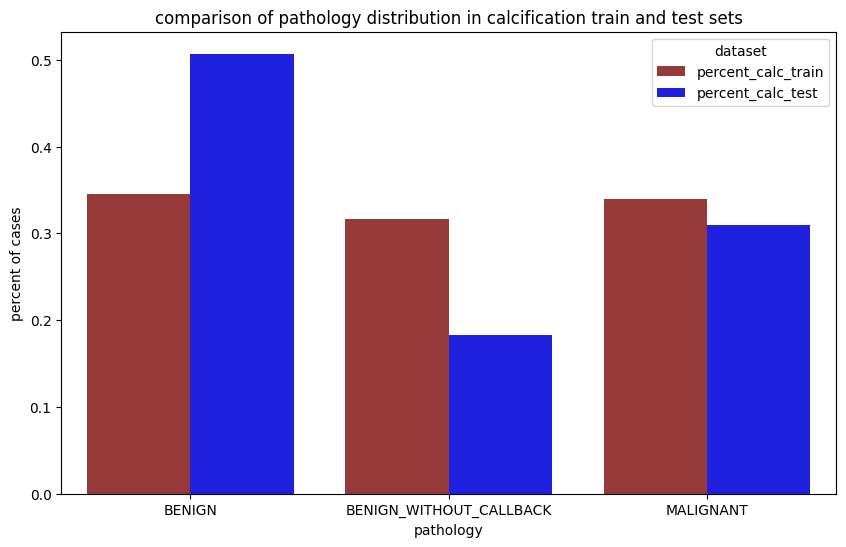

In [37]:
train_dist = calc_train['pathology'].value_counts(normalize=True).reset_index()
train_dist.columns = ['pathology', 'percent_calc_train']

test_dist = calc_test['pathology'].value_counts(normalize=True).reset_index()
test_dist.columns = ['pathology', 'percent_calc_test']

comparison_df = pd.merge(train_dist, test_dist, on='pathology', how='outer')

comparison_melted = pd.melt(comparison_df, id_vars='pathology', value_vars=['percent_calc_train', 'percent_calc_test'],
                            var_name='dataset', value_name='percent')

plt.figure(figsize=(10, 6))
sns.barplot(x='pathology', y='percent', hue='dataset', data=comparison_melted, palette=['brown', 'blue'])

plt.title('comparison of pathology distribution in calcification train and test sets')
plt.xlabel('pathology')
plt.ylabel('percent of cases')

plt.show()

**This graph compares the percentage of pathology types (Benign, Benign Without Callback, and Malignant) in two datasets: training (brown) and testing (blue).**

 ***Benign: The training set has about 0.35 (35%), while the test set has around 0.5 (50%). The test set has more benign cases*** 
 
***Benign Without Callback: Both sets are similar, around 0.3 (30%).***

***Malignant: Both sets are also close, around 0.35 (35%) for training and 0.3 (30%) for testing.***

**This shows the test set has more benign cases, but the other categories are fairly balanced between the two sets.**

In [47]:
!pip uninstall scikit-learn -y
!pip cache purge


Files removed: 0


In [48]:
!pip install numpy scipy joblib threadpoolctl
!pip install scikit-learn==1.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 79.0 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


# Mapping diagnosis to binary classes
DIAGNOSIS_MAPPING = {
    'BENIGN': 0,
    'BENIGN_WITHOUT_CALLBACK': 0,
    'MALIGNANT': 1
}

def preprocess_raw_dataset(df: pd.DataFrame, dataset_name: str) -> pd.DataFrame:
    """
    Preprocess the raw dataset: handle missing values, encode labels, and scale numeric features.
    """
    print(f"\nInitial missing values in '{dataset_name}':\n{df.isnull().sum()}")

    df = df.copy()

    # Fill missing categorical fields with 'UNKNOWN'
    for col in ['mass_shape', 'mass_margins', 'calc_type', 'calc_distribution']:
        if col in df.columns:
            df[col].fillna('UNKNOWN', inplace=True)

    # Encode diagnosis labels
    df['diagnosis_encoded'] = df['pathology'].map(DIAGNOSIS_MAPPING)

    # Handle unexpected pathology values
    if df['diagnosis_encoded'].isnull().any():
        unmapped = df[df['diagnosis_encoded'].isnull()]['pathology'].unique()
        print(f"Warning: Unmapped pathology labels in '{dataset_name}': {unmapped}")
        df['diagnosis_encoded'].fillna(0, inplace=True)  # Defaulting to benign

    # Scale numeric columns (except IDs and encoded diagnosis)
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.difference(['abnormality_id', 'diagnosis_encoded'])
    if not numeric_cols.empty:
        scaler = StandardScaler()
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    print(f"\nFinal missing values in '{dataset_name}':\n{df.isnull().sum()}")

    # Save the processed dataset
    output_path = f"/kaggle/working/{dataset_name}_preprocessed.csv"
    df.to_csv(output_path, index=False)
    print(f"Processed dataset saved to: {output_path}")

    return df

def select_relevant_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Keep only relevant features for modeling and ensure the 'pathology' is binary encoded.
    """
    df = df.copy()
    df['pathology'] = df['pathology'].map(DIAGNOSIS_MAPPING)

    selected_features = [
        'breast_density', 'left_or_right_breast', 'image_view', 
        'abnormality_type', 'mass_shape', 'mass_margins',
        'calc_type', 'calc_distribution', 'assessment', 
        'subtlety', 'type', 'pathology'
    ]

    available_features = [col for col in selected_features if col in df.columns]
    return df[available_features]

def build_preprocessing_pipeline(categorical_cols, numerical_cols):
    """
    Build a ColumnTransformer for numeric and categorical preprocessing.
    """
    numeric_pipeline = Pipeline([
        ('scaler', StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ])

    return preprocessor

def process_train_test(train_df: pd.DataFrame, test_df: pd.DataFrame, dataset_label: str):
    """
    Full preprocessing pipeline: feature selection, encoding, scaling, splitting X/y.
    """
    print(f"\n--- Processing dataset: {dataset_label} ---")

    train_df = select_relevant_features(train_df)
    test_df = select_relevant_features(test_df)

    # Split features and labels
    X_train = train_df.drop(columns='pathology')
    y_train = train_df['pathology']
    X_test = test_df.drop(columns='pathology')
    y_test = test_df['pathology']

    # Identify column types
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

    print(f"Categorical features: {categorical_cols}")
    print(f"Numerical features: {numerical_cols}")

    # Build and apply pipeline
    preprocessor = build_preprocessing_pipeline(categorical_cols, numerical_cols)
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Display class distribution
    print(f"\nClass distribution in '{dataset_label}' training set:\n{y_train.value_counts()}")

    return X_train_processed, y_train, X_test_processed, y_test

def load_datasets():
    """
    Load all datasets from disk.
    """
    mass_train = pd.read_csv("/kaggle/working/mass_train_final.csv")
    mass_test = pd.read_csv("/kaggle/working/mass_test_final.csv")
    calc_train = pd.read_csv("/kaggle/working/calc_train_final.csv")
    calc_test = pd.read_csv("/kaggle/working/calc_test_final.csv")
    return mass_train, mass_test, calc_train, calc_test

def main():
    # Load raw datasets
    mass_train, mass_test, calc_train, calc_test = load_datasets()

# Preprocess the datasets
    mass_train_processed = preprocess_raw_dataset(mass_train, "mass_train")
    mass_test_processed = preprocess_raw_dataset(mass_test, "mass_test")
    calc_train_processed = preprocess_raw_dataset(calc_train, "calc_train")
    calc_test_processed = preprocess_raw_dataset(calc_test, "calc_test")

    # Final feature engineering and processing
    print("\nProcessing MASS dataset...")
    X_mass_train, y_mass_train, X_mass_test, y_mass_test = process_train_test(mass_train, mass_test, "MASS")

    print("\nProcessing CALC dataset...")
    X_calc_train, y_calc_train, X_calc_test, y_calc_test = process_train_test(calc_train, calc_test, "CALC")

if __name__ == "__main__":
    main()


Initial missing values in 'mass_train':
patient_id               0
breast_density           0
left_or_right_breast     0
image_view               0
abnormality_id           0
abnormality_type         0
mass_shape               0
mass_margins            12
assessment               0
pathology                0
subtlety                 0
type                     0
dataset                  0
image_path               0
dtype: int64

Final missing values in 'mass_train':
patient_id              0
breast_density          0
left_or_right_breast    0
image_view              0
abnormality_id          0
abnormality_type        0
mass_shape              0
mass_margins            0
assessment              0
pathology               0
subtlety                0
type                    0
dataset                 0
image_path              0
diagnosis_encoded       0
dtype: int64
Processed dataset saved to: /kaggle/working/mass_train_preprocessed.csv

Initial missing values in 'mass_test':
patient_id    

/tmp/ipykernel_31/3398918928.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('UNKNOWN', inplace=True)
/tmp/ipykernel_31/3398918928.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
import cv2

def perform_comprehensive_eda(df, dataset_name, sample_images=5):
    """
    Comprehensive EDA tailored for CBIS-DDSM dataset combining clinical and imaging features.
    """
    print(f"\n=== {dataset_name.upper()} COMPREHENSIVE EDA ===\n")
    
    # Target Column
    target_col = 'diagnosis_encoded' if 'diagnosis_encoded' in df.columns else 'pathology'
    
    ## 1. Class Distribution
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.countplot(x=target_col, data=df, ax=axes[0], palette='pastel')
    axes[0].set_title('Class Distribution')
    axes[0].bar_label(axes[0].containers[0])
    
    df[target_col].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[1], colors=sns.color_palette('pastel'))
    axes[1].set_title('Class Proportion')
    axes[1].set_ylabel('')
    plt.tight_layout()
    plt.show()

    ## 2. Clinical Features Distribution
    clinical_features = ['assessment', 'subtlety', 'breast_density', 'image_view', 'left_or_right_breast']
    clinical_features = [f for f in clinical_features if f in df.columns]
    
    if clinical_features:
        for feature in clinical_features:
            plt.figure(figsize=(8, 4))
            if df[feature].dtype == 'object':
                sns.countplot(x=feature, hue=target_col, data=df, palette='Set2')
                plt.title(f"{feature} Distribution by {target_col}")
            else:
                sns.boxplot(x=target_col, y=feature, data=df, palette='Set2')
                plt.title(f"{feature} Distribution by {target_col}")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

    ## 3. Image Statistics (if available)
    if 'image_path' in df.columns:
        try:
            print("\nCalculating basic image statistics...")
            df['image_stats'] = df['image_path'].apply(lambda x: get_image_stats(x))
            stats_df = pd.json_normalize(df['image_stats'])
            
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))
            sns.histplot(stats_df['mean_pixel_value'], kde=True, ax=axes[0, 0])
            axes[0, 0].set_title('Mean Pixel Value Distribution')

            sns.histplot(stats_df['std_pixel_value'], kde=True, ax=axes[0, 1])
            axes[0, 1].set_title('Pixel Value Std Dev Distribution')

            sns.scatterplot(x='width', y='height', hue=df[target_col], data=stats_df, ax=axes[1, 0], palette='tab10')
            axes[1, 0].set_title('Image Width vs Height')

            sns.scatterplot(x='mean_pixel_value', y='std_pixel_value', hue=df[target_col], data=stats_df, ax=axes[1, 1], palette='tab10')
            axes[1, 1].set_title('Mean vs Std Dev of Pixels')

            plt.tight_layout()
            plt.show()

            display_sample_images(df, sample_images, target_col)

        except Exception as e:
            print(f"Image analysis failed: {e}")

    ## 4. Correlation Matrix for Numeric Features
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != target_col]
    
    if numeric_cols:
        plt.figure(figsize=(10, 8))
        corr = df[numeric_cols].corr()
        sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", square=True, cbar=True)
        plt.title(f'{dataset_name} Clinical Feature Correlation')
        plt.show()

    ## 5. Feature Importance (Mutual Information)
    X = df.drop([target_col, 'image_path', 'image_stats'], axis=1, errors='ignore')
    y = df[target_col]
    
    # Encode categorical variables
    for col in X.select_dtypes(include='object'):
        X[col] = LabelEncoder().fit_transform(X[col])
    
    if not X.empty:
        mi = mutual_info_classif(X, y, random_state=42)
        mi_df = pd.DataFrame({'Feature': X.columns, 'MI_Score': mi}).sort_values('MI_Score', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='MI_Score', y='Feature', data=mi_df, palette='viridis')
        plt.title('Top Features by Mutual Information')
        plt.tight_layout()
        plt.show()

        return mi_df
    else:
        print("No features available for Mutual Information analysis.")
        return None


def get_image_stats(image_path):
    """Extract simple image stats."""
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return {'mean_pixel_value': np.nan, 'std_pixel_value': np.nan, 'width': np.nan, 'height': np.nan}
        return {
            'mean_pixel_value': np.mean(img),
            'std_pixel_value': np.std(img),
            'width': img.shape[1],
            'height': img.shape[0]
        }
    except:
        return {'mean_pixel_value': np.nan, 'std_pixel_value': np.nan, 'width': np.nan, 'height': np.nan}


def display_sample_images(df, n=5, target_col='diagnosis_encoded'):
    """Display random sample images from each class."""
    plt.figure(figsize=(15, 6))
    classes = df[target_col].unique()
    samples_per_class = max(1, n // len(classes))
    
    for i, cls in enumerate(classes):
        sample_rows = df[df[target_col] == cls].sample(samples_per_class, replace=True)
        for j, (_, row) in enumerate(sample_rows.iterrows()):
            try:
                img = cv2.imread(row['image_path'])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.subplot(len(classes), samples_per_class, i * samples_per_class + j + 1)
                plt.imshow(img)
                plt.title(f"{cls}")
                plt.axis('off')
            except:
                continue
    plt.tight_layout()
    plt.show()


=== MASS COMPREHENSIVE EDA ===



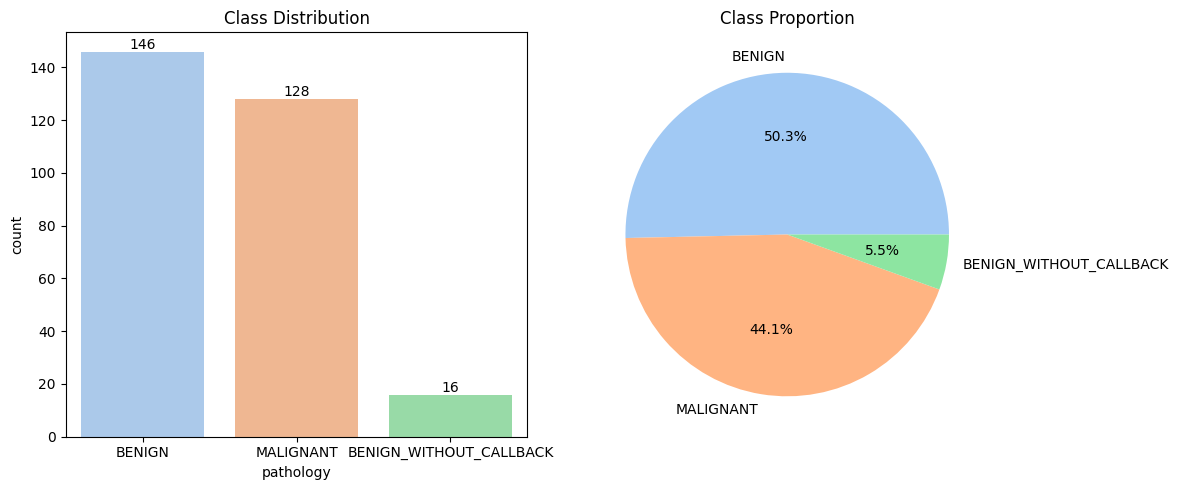

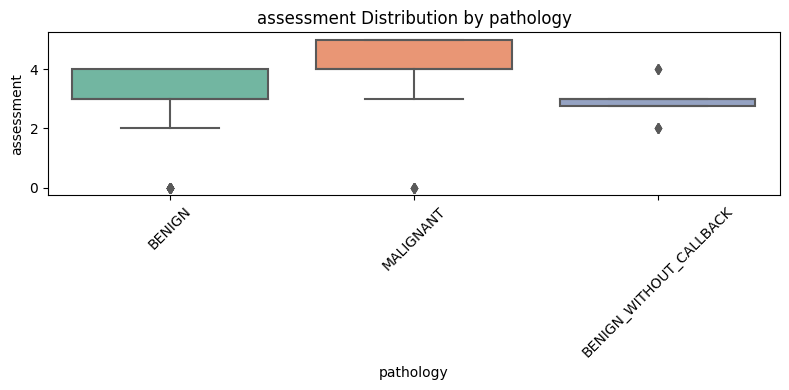

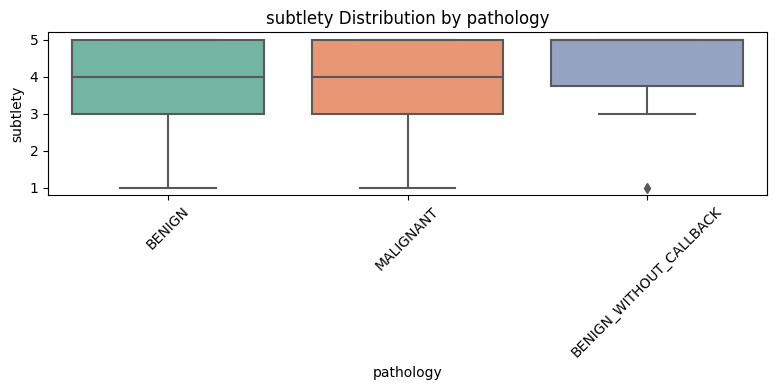

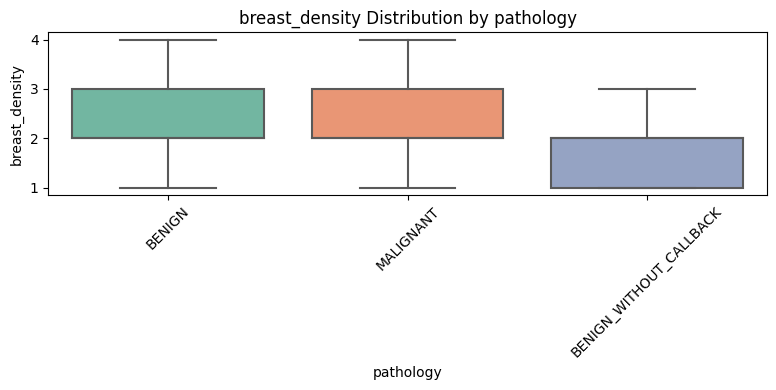

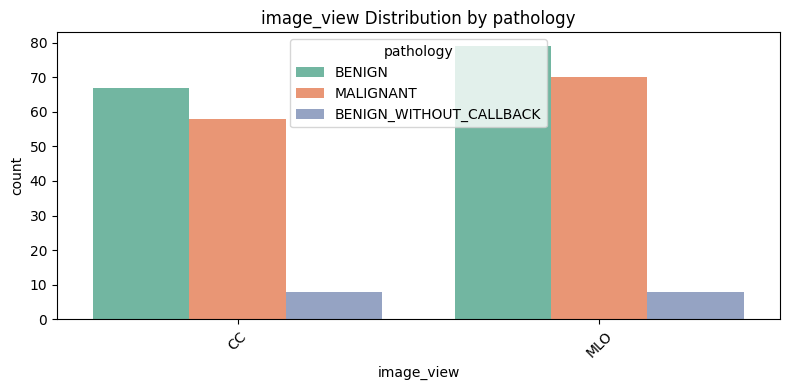

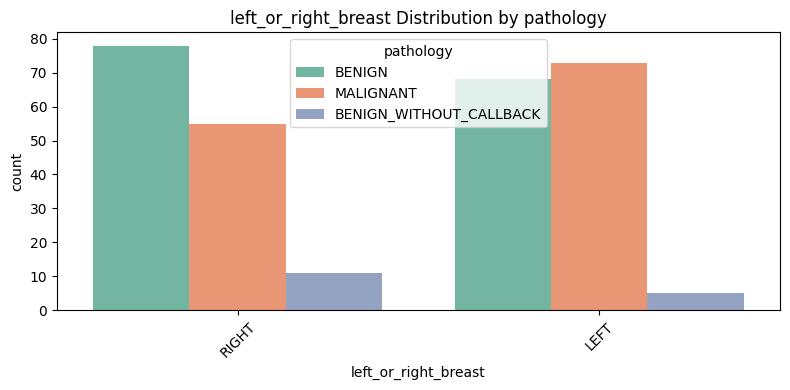


Calculating basic image statistics...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


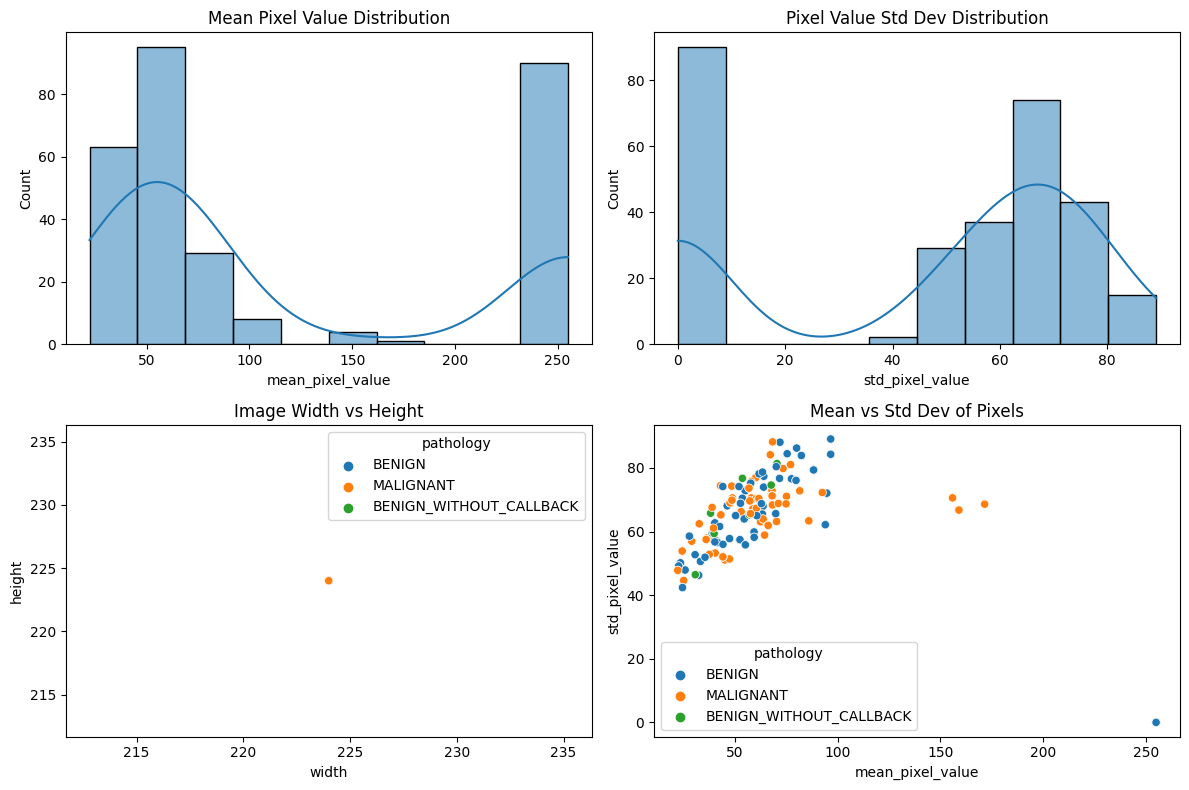

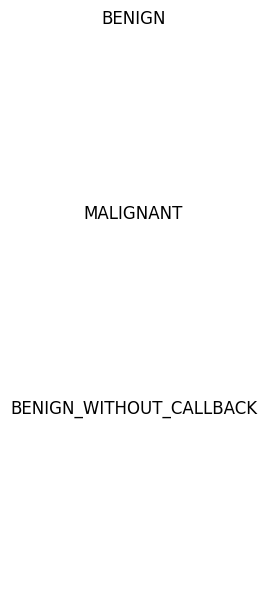

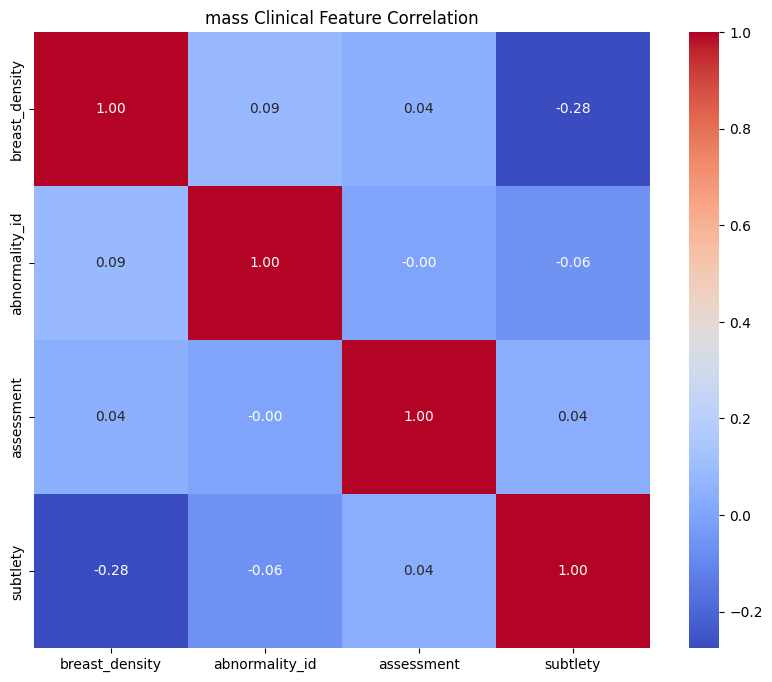

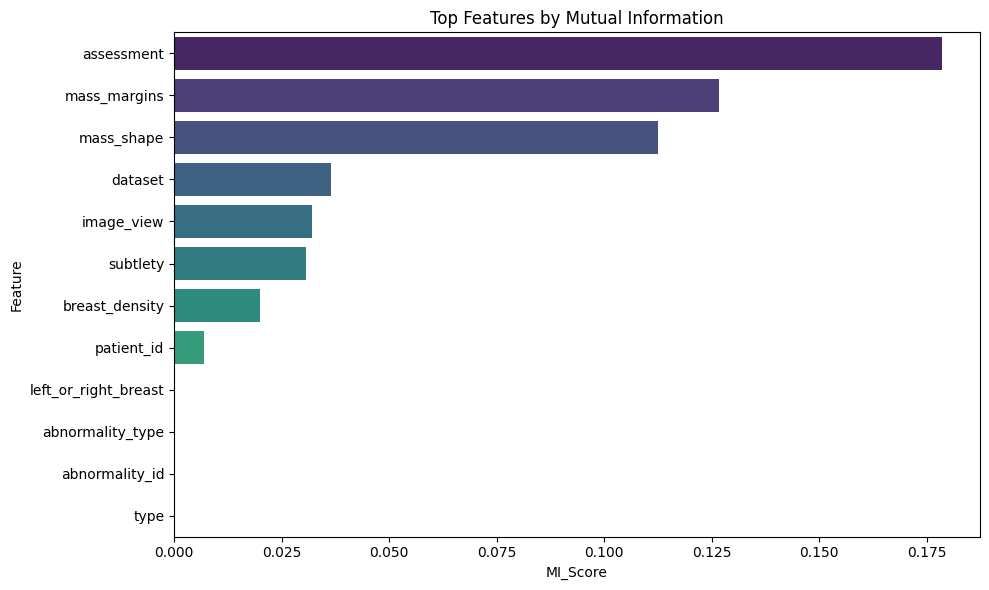


=== CALC COMPREHENSIVE EDA ===



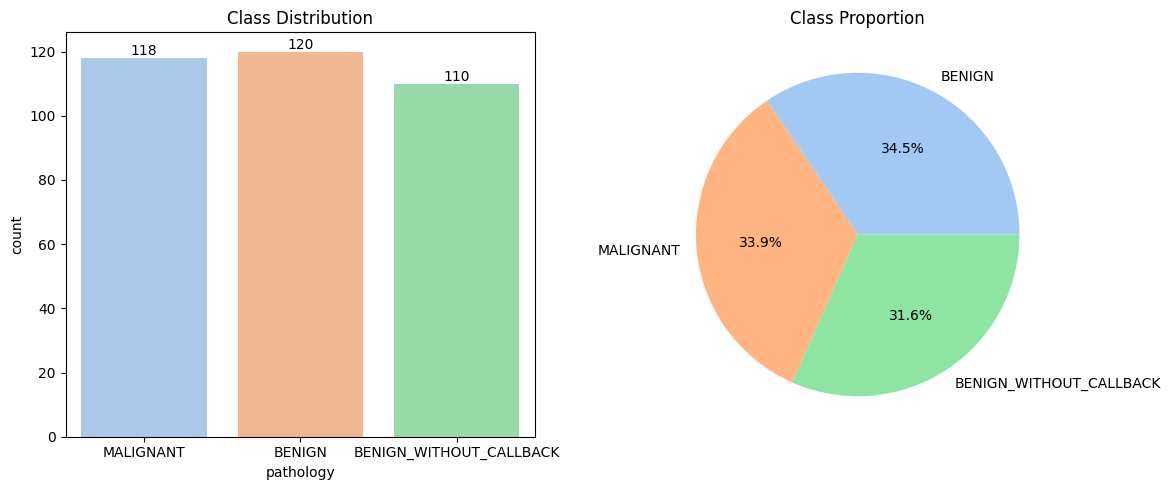

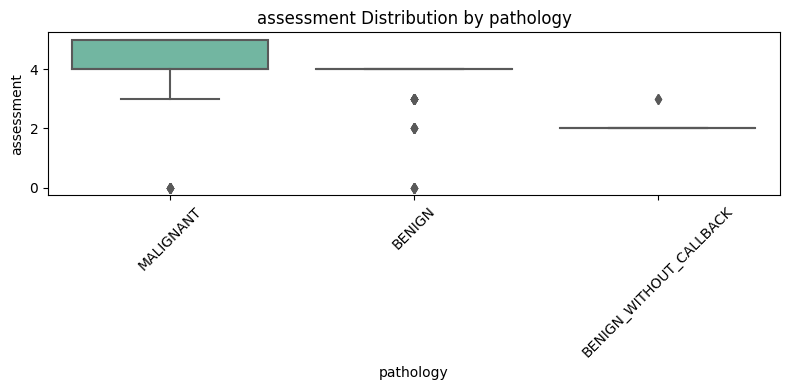

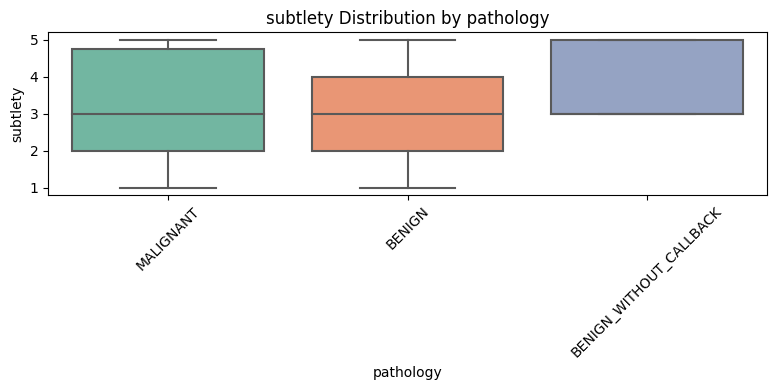

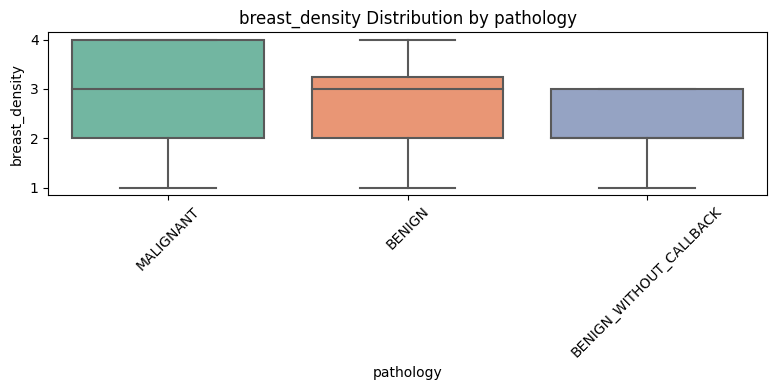

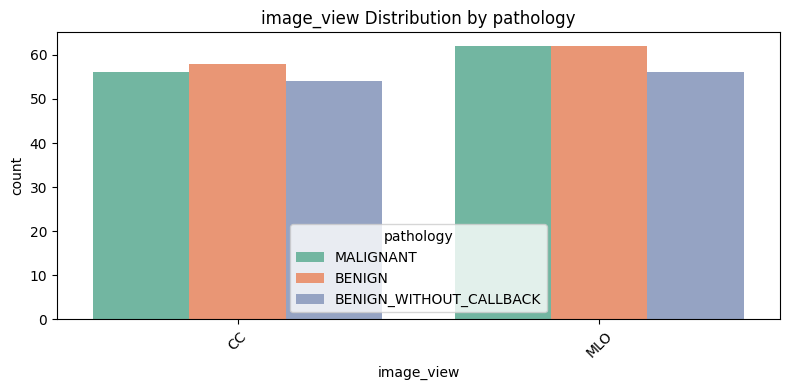

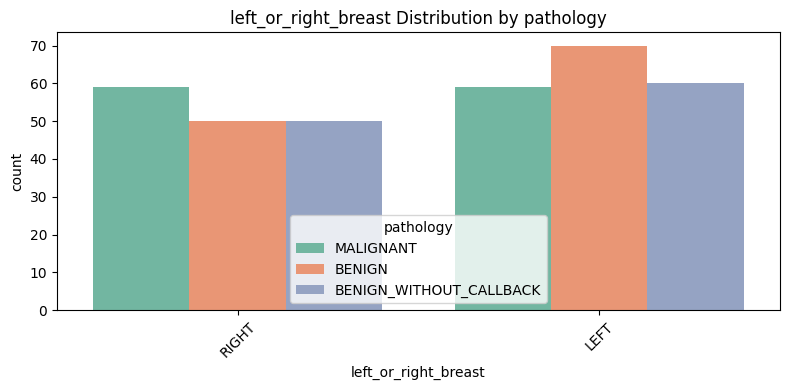


Calculating basic image statistics...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


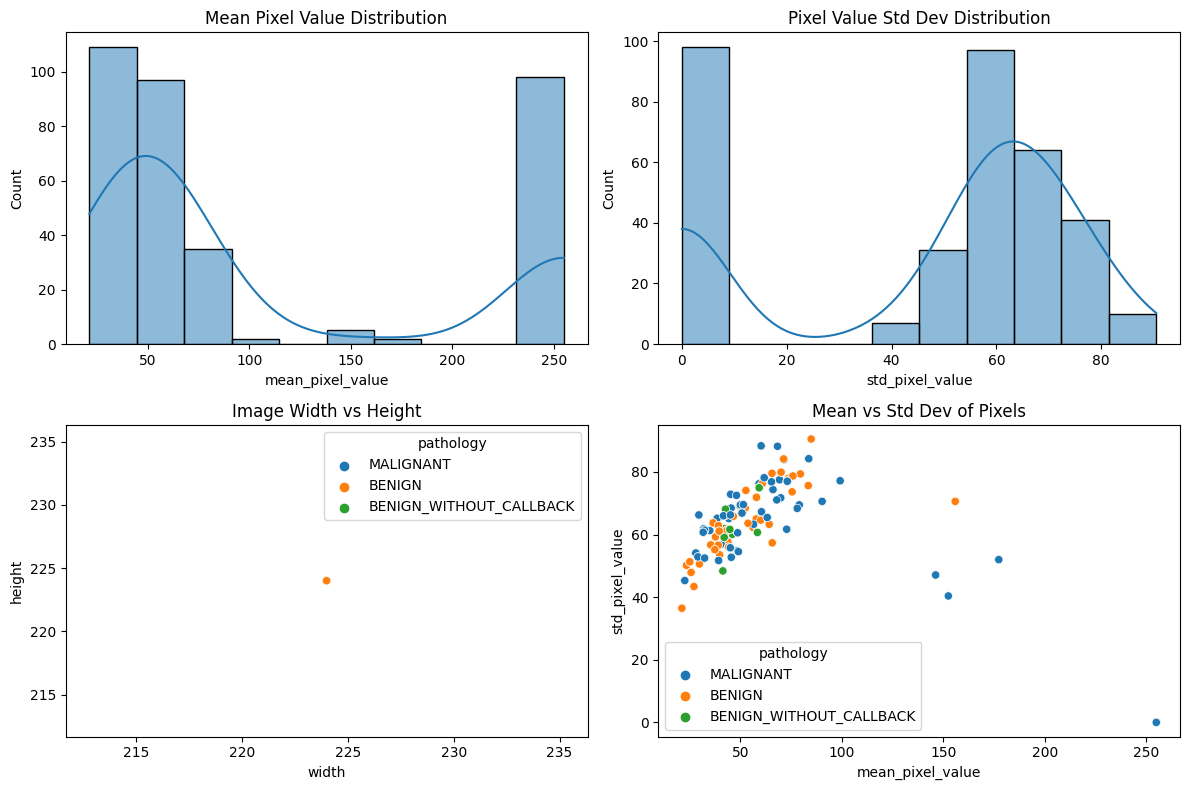

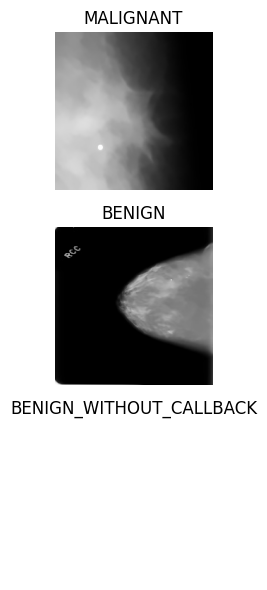

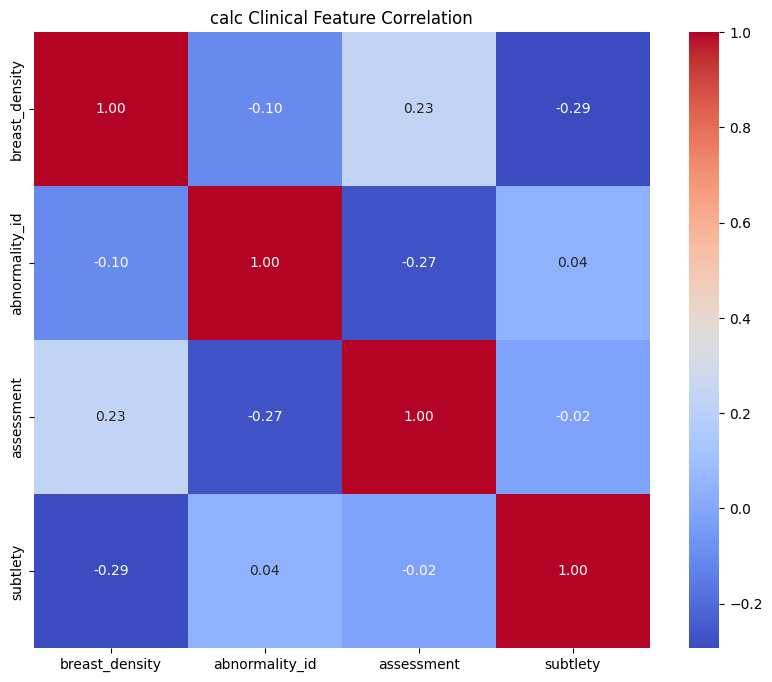

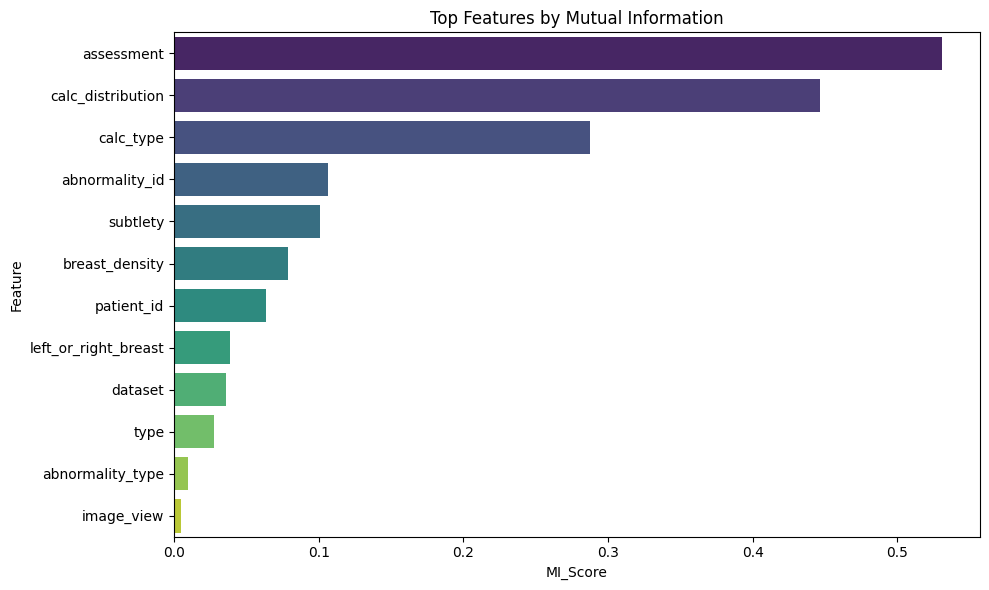

,Feature,MI_Score
8,assessment,0.530535
7,calc_distribution,0.446633
6,calc_type,0.287729
4,abnormality_id,0.106122
9,subtlety,0.100879
1,breast_density,0.078754
0,patient_id,0.063660
2,left_or_right_breast,0.038850
11,dataset,0.036241
10,type,0.027693


In [52]:
mass_path = "/kaggle/working/mass_train_final.csv"
calc_path = "/kaggle/working/calc_train_final.csv"

# Run EDA for both datasets
perform_comprehensive_eda(pd.read_csv(mass_path), "mass")
perform_comprehensive_eda(pd.read_csv(calc_path), "calc")

In [53]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, Dropout, GlobalAveragePooling2D,
                                    concatenate, BatchNormalization, Add, Lambda,
                                    Conv2D, UpSampling2D, MultiHeadAttention, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- Combined Data Generator ---
class CombinedDataGenerator(Sequence):
    def __init__(self, df, image_size=(224, 224), batch_size=32, tabular_features=None, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.tabular_features = tabular_features or [
            'assessment', 'subtlety', 'breast_density',
            'image_view', 'left_or_right_breast'
        ]
        self.on_epoch_end()
        self._fit_transformer()

    def _fit_transformer(self):
        tabular_data = self.df[self.tabular_features]
        self.numeric_features = tabular_data.select_dtypes(include=['number']).columns.tolist()
        self.categorical_features = tabular_data.select_dtypes(include=['object']).columns.tolist()
        
        # Updated OneHotEncoder to use sparse_output instead of sparse
        self.transformer = ColumnTransformer([
            ('num', StandardScaler(), self.numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), self.categorical_features)
        ])
        self.transformer.fit(tabular_data)
        self.tabular_shape = self.transformer.transform(tabular_data.iloc[:1]).shape[1]

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        images, tabular_data, labels = [], [], []

        for _, row in batch_df.iterrows():
            try:
                image = self.load_image(row['image_path'])
                tabular = self.get_tabular(row)
                label = row['diagnosis_encoded']
                images.append(image)
                tabular_data.append(tabular)
                labels.append(label)
            except Exception as e:
                print(f"[WARNING] Failed to load sample: {e}")
                continue

        if len(images) == 0:
            dummy_image = np.zeros((1, *self.image_size, 3), dtype=np.float32)
            dummy_tabular = np.zeros((1, self.tabular_shape), dtype=np.float32)
            dummy_label = np.array([0], dtype=np.float32)
            return ((dummy_image, dummy_tabular), dummy_label)

        images = np.array(images)
        tabular_data = pd.DataFrame(tabular_data, columns=self.tabular_features)
        tabular_data = self.transformer.transform(tabular_data)
        labels = np.array(labels)

        return ((images, tabular_data), labels)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def load_image(self, path):
        image = cv2.imread(path)
        if image is None:
            raise ValueError(f"Image not found: {path}")
        image = cv2.resize(image, self.image_size)
        return image.astype(np.float32) / 255.0

    def get_tabular(self, row):
        return [row[feat] for feat in self.tabular_features]

    def as_dataset(self):
        def gen():
            while True:
                for i in range(len(self)):
                    yield self[i]
        output_types = ((tf.float32, tf.float32), tf.float32)
        output_shapes = ((tf.TensorShape([None, *self.image_size, 3]),
                          tf.TensorShape([None, self.tabular_shape])),
                         tf.TensorShape([None]))
        return tf.data.Dataset.from_generator(gen, output_types, output_shapes)

In [54]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate, BatchNormalization, Lambda, Conv2D, MultiHeadAttention, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.metrics import AUC

class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0, name="focal_loss"):
        super().__init__(name=name)
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        # Ensure shapes match by expanding y_true dimensions if needed
        y_true = tf.expand_dims(y_true, axis=-1)  # Convert (None,) to (None, 1)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)
        p_t = tf.math.exp(-bce)
        loss = self.alpha * tf.math.pow(1-p_t, self.gamma) * bce
        return tf.reduce_mean(loss)
                             
def create_stable_model(image_shape, tabular_input_shape):
    # Image Pathway
    img_input = Input(shape=image_shape)

    # 1. Check for weights file or download:
    WEIGHTS_PATH = "/kaggle/input/resnet50-weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"  
    if os.path.exists(WEIGHTS_PATH):
        print("Weights file found!")
        weights = WEIGHTS_PATH
    else:
        print("Weights file NOT found! Using 'imagenet' weights.")
        weights = 'imagenet'  # Fallback to ImageNet weights

    base_model = ResNet50(weights=weights, include_top=False, input_tensor=img_input)

    base_model.trainable = False
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Tabular Pathway
    tab_input = Input(shape=(tabular_input_shape,))
    y = Dense(128, activation='relu')(tab_input)
    y = BatchNormalization()(y)
    y = Dropout(0.3)(y)
    
    # Combined Model
    combined = Concatenate()([x, y])
    z = Dense(256, activation='relu')(combined)
    z = BatchNormalization()(z)
    output = Dense(1, activation='sigmoid')(z)
    
    return Model(inputs=[img_input, tab_input], outputs=output)

def train_stable_model(data_type='mass'):
    # Load data
    train_df = pd.read_csv(f"/kaggle/working/{data_type}_train_preprocessed.csv")
    test_df = pd.read_csv(f"/kaggle/working/{data_type}_test_preprocessed.csv")

    # Data generator
    features = ['assessment', 'subtlety', 'breast_density', 'image_view', 'left_or_right_breast']
    train_gen = CombinedDataGenerator(train_df, tabular_features=features)
    test_gen = CombinedDataGenerator(test_df, tabular_features=features, shuffle=False)

    # Model
    model = create_stable_model((224, 224, 3), train_gen.tabular_shape)

    # Verify data shapes
    sample_batch = next(iter(train_gen.as_dataset()))
    print("Sample batch shapes:")
    print(f"Images: {sample_batch[0][0].shape}")
    print(f"Tabular: {sample_batch[0][1].shape}")
    print(f"Labels: {sample_batch[1].shape}")

    # Compile with standard BCE
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )

    # Callbacks
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True, monitor='val_auc'),
        ModelCheckpoint(f"best_{data_type}_model.keras", save_best_only=True),
        ReduceLROnPlateau(factor=0.5, patience=3)
    ]

    # Train
    history = model.fit(
        train_gen.as_dataset().prefetch(tf.data.AUTOTUNE),
        steps_per_epoch=len(train_gen),
        validation_data=test_gen.as_dataset().prefetch(tf.data.AUTOTUNE),
        validation_steps=len(test_gen),
        epochs=35,
        callbacks=callbacks
    )
    
    return model, history

if __name__ == "__main__":
    print("Training MASS model...")
    mass_model, mass_history = train_stable_model('mass')

Training MASS model...
Weights file NOT found! Using 'imagenet' weights.


I0000 00:00:1746311722.264176      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Sample batch shapes:
Images: (32, 224, 224, 3)
Tabular: (32, 7)
Labels: (32,)
Epoch 1/35


I0000 00:00:1746311740.074372     219 service.cc:148] XLA service 0x788980002700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746311740.075457     219 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746311741.573212     219 cuda_dnn.cc:529] Loaded cuDNN version 90300


 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4635 - auc: 0.4752 - loss: 0.8863

I0000 00:00:1746311746.713806     219 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5270 - auc: 0.5498 - loss: 0.8078 - val_accuracy: 0.3951 - val_auc: 0.7918 - val_loss: 0.7401 - learning_rate: 1.0000e-04
Epoch 2/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.6445 - auc: 0.7231 - loss: 0.6168 - val_accuracy: 0.3951 - val_auc: 0.8195 - val_loss: 0.7338 - learning_rate: 1.0000e-04
Epoch 3/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7135 - auc: 0.8096 - loss: 0.5448 - val_accuracy: 0.3951 - val_auc: 0.8115 - val_loss: 0.7384 - learning_rate: 1.0000e-04
Epoch 4/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7521 - auc: 0.8383 - loss: 0.5056 - val_accuracy: 0.3951 - val_auc: 0.8125 - val_loss: 0.7519 - learning_rate: 1.0000e-04
Epoch 5/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7933 - auc: 0.8585 - loss: 0.4723 - val_accuracy: 0.3951 - val_auc: 0.8233 - val_loss: 0.7632 - learning_rate: 1.0000e-04
Epoch 6/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7843 - auc:

In [56]:
print("\nTraining CALC model...")
calc_model, calc_history = train_stable_model('calc')


Training CALC model...
Weights file NOT found! Using 'imagenet' weights.
Sample batch shapes:
Images: (32, 224, 224, 3)
Tabular: (32, 7)
Labels: (32,)
Epoch 1/35
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5972 - auc: 0.6770 - loss: 0.7229 - val_accuracy: 0.3099 - val_auc: 0.6248 - val_loss: 0.8057 - learning_rate: 1.0000e-04
Epoch 2/35
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.7110 - auc: 0.7749 - loss: 0.6121 - val_accuracy: 0.3099 - val_auc: 0.6466 - val_loss: 0.7950 - learning_rate: 1.0000e-04
Epoch 3/35
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.7421 - auc: 0.8577 - loss: 0.5103 - val_accuracy: 0.3099 - val_auc: 0.6331 - val_loss: 0.7717 - learning_rate: 1.0000e-04
Epoch 4/35
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.7931 - auc: 0.8855 - loss: 0.4560 - val_accuracy: 0.3099 - val_auc: 0.6289 - val_loss: 0.7438 - learning_rate: 1.0000e-04
Epoch 5/35
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.8088 - auc: 0.8795 - loss: 0.467

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_curve, auc, precision_recall_curve)
import seaborn as sns

class BreastCancerModelValidator:
    def __init__(self, model, test_gen):
        self.model = model
        self.test_gen = test_gen
        self.y_true = None
        self.y_probs = None
        self.y_pred = None
        
    def evaluate(self, threshold=0.5):
        """Comprehensive model evaluation"""
        self._collect_predictions()
        self.y_pred = (self.y_probs >= threshold).astype(int)
        
        print("\n=== Basic Metrics ===")
        self._calculate_basic_metrics()
        
        print("\n=== Clinical Metrics ===")
        self._calculate_clinical_metrics()
        
        print("\n=== Visualizations ===")
        self._generate_visualizations()
        
        print("\n=== Threshold Analysis ===")
        self._threshold_analysis()
    
    def _collect_predictions(self):
        """Collect all predictions and true labels"""
        y_true, y_probs = [], []
        for i in range(len(self.test_gen)):
            (x_img, x_tab), y = self.test_gen[i]
            y_true.extend(y)
            y_probs.extend(self.model.predict([x_img, x_tab], verbose=0).flatten())
        
        self.y_true = np.array(y_true)
        self.y_probs = np.array(y_probs)
    
    def _calculate_basic_metrics(self):
        """Standard performance metrics"""
        print(classification_report(self.y_true, self.y_pred))
        
        # Confusion matrix with percentages
        cm = confusion_matrix(self.y_true, self.y_pred)
        cm_percent = cm / cm.sum(axis=1)[:, np.newaxis] * 100
        print("\nConfusion Matrix (%):")
        print(np.round(cm_percent, 1))
        
        # AUC-ROC
        fpr, tpr, _ = roc_curve(self.y_true, self.y_probs)
        print(f"\nAUC-ROC: {auc(fpr, tpr):.3f}")
    
    def _calculate_clinical_metrics(self):
        """Cancer-specific metrics"""
        tn, fp, fn, tp = confusion_matrix(self.y_true, self.y_pred).ravel()
        
        metrics = {
            'Sensitivity (Recall)': tp / (tp + fn),
            'Specificity': tn / (tn + fp),
            'PPV (Precision)': tp / (tp + fp),
            'NPV': tn / (tn + fn),
            'False Omission Rate': fn / (fn + tn),
            'F1 Score': 2*tp / (2*tp + fp + fn)
        }
        
        for name, value in metrics.items():
            print(f"{name}: {value:.3f}")
        
        # Benchmark comparison
        print("\nClinical Benchmarks:")
        print("Sensitivity >85% (Recommended for cancer detection)")
        print(f"AUC >0.80 (Yours: {auc(*roc_curve(self.y_true, self.y_probs)[:2]):.3f})")
    
    def _generate_visualizations(self):
        """Generate diagnostic plots"""
        plt.figure(figsize=(15, 4))
        
        # ROC Curve
        plt.subplot(1, 3, 1)
        fpr, tpr, _ = roc_curve(self.y_true, self.y_probs)
        plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        
        # Precision-Recall Curve
        plt.subplot(1, 3, 2)
        precision, recall, _ = precision_recall_curve(self.y_true, self.y_probs)
        plt.plot(recall, precision)
        plt.xlabel('Recall (Sensitivity)')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        
        # Confidence Distribution
        plt.subplot(1, 3, 3)
        sns.histplot(self.y_probs, bins=20, kde=True)
        plt.axvline(0.5, color='r', linestyle='--')
        plt.title('Prediction Confidence Distribution')
        plt.tight_layout()
        plt.show()
    
    def _threshold_analysis(self):
        """Find optimal operating point"""
        # Find threshold at 90% sensitivity
        precision, recall, thresholds = precision_recall_curve(self.y_true, self.y_probs)
        optimal_idx = np.argmax(recall >= 0.90)
        optimal_threshold = thresholds[optimal_idx]
        
        print(f"Threshold for 90% Sensitivity: {optimal_threshold:.3f}")
        print(f"Corresponding Precision: {precision[optimal_idx]:.3f}")
        
        # Threshold vs Metrics
        results = []
        for thresh in np.linspace(0.1, 0.9, 9):
            preds = (self.y_probs >= thresh).astype(int)
            tn, fp, fn, tp = confusion_matrix(self.y_true, preds).ravel()
            results.append({
                'Threshold': thresh,
                'Sensitivity': tp / (tp + fn),
                'Specificity': tn / (tn + fp),
                'F1': 2*tp / (2*tp + fp + fn)
            })
        
        threshold_df = pd.DataFrame(results)
        print("\nThreshold Analysis:")
        print(threshold_df.round(3))
    
    def error_analysis(self, test_df, n_samples=5):
        """Visualize misclassified cases"""
        wrong_indices = []
        for i in range(len(self.test_gen)):
            (x_img, x_tab), y = self.test_gen[i]
            preds = self.model.predict([x_img, x_tab], verbose=0).flatten()
            batch_labels = y
            for j in range(len(batch_labels)):
                if (preds[j] >= 0.5) != batch_labels[j]:
                    wrong_indices.append((i, j))  # (batch_idx, sample_idx)
        
        print(f"\nFound {len(wrong_indices)} misclassified samples")
        
        # Visualize some errors
        for i, (batch_idx, sample_idx) in enumerate(wrong_indices[:n_samples]):
            (x_img, x_tab), y = self.test_gen[batch_idx]
            img = x_img[sample_idx]
            true_label = y[sample_idx]
            pred_prob = self.model.predict(
                [np.expand_dims(img, 0), np.expand_dims(x_tab[sample_idx], 0)],
                verbose=0
            )[0][0]
            
            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.title(f"True: {true_label}\nPred: {pred_prob:.3f}")
            plt.axis('off')
            plt.show()
            
            # Show associated tabular data
            print(f"Tabular Features:\n{self.test_gen.tabular_features}")

            print(x_tab[sample_idx])


Training and evaluating MASS model...
Weights file NOT found! Using 'imagenet' weights.

=== Basic Metrics ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.40      1.00      0.57        32

    accuracy                           0.40        81
   macro avg       0.20      0.50      0.28        81
weighted avg       0.16      0.40      0.22        81


Confusion Matrix (%):
[[  0. 100.]
 [  0. 100.]]

AUC-ROC: 0.735

=== Clinical Metrics ===
Sensitivity (Recall): 1.000
Specificity: 0.000
PPV (Precision): 0.395
NPV: nan
False Omission Rate: nan
F1 Score: 0.566

Clinical Benchmarks:
Sensitivity >85% (Recommended for cancer detection)
AUC >0.80 (Yours: 0.735)

=== Visualizations ===


/tmp/ipykernel_31/2668685817.py:66: RuntimeWarning: invalid value encountered in scalar divide
  'NPV': tn / (tn + fn),
/tmp/ipykernel_31/2668685817.py:67: RuntimeWarning: invalid value encountered in scalar divide
  'False Omission Rate': fn / (fn + tn),


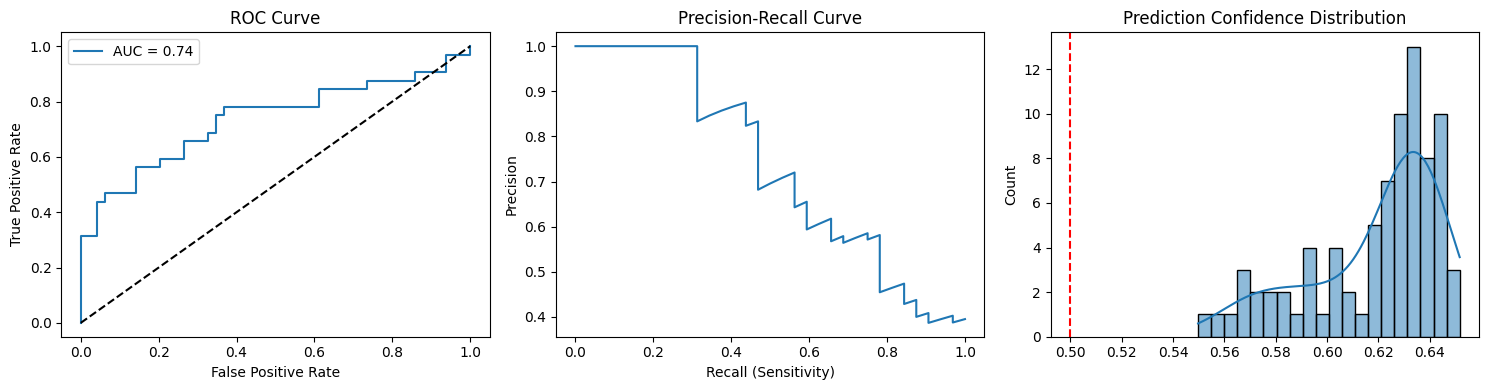


=== Threshold Analysis ===
Threshold for 90% Sensitivity: 0.550
Corresponding Precision: 0.395

Threshold Analysis:
   Threshold  Sensitivity  Specificity     F1
0        0.1        1.000        0.000  0.566
1        0.2        1.000        0.000  0.566
2        0.3        1.000        0.000  0.566
3        0.4        1.000        0.000  0.566
4        0.5        1.000        0.000  0.566
5        0.6        0.844        0.265  0.568
6        0.7        0.000        1.000  0.000
7        0.8        0.000        1.000  0.000
8        0.9        0.000        1.000  0.000

Training and evaluating CALC model...
Weights file NOT found! Using 'imagenet' weights.

=== Basic Metrics ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.31      1.00      0.47        22

    accuracy                           0.31        71
   macro avg       0.15      0.50      0.24        71
weighted avg       0.10      0.31      

/tmp/ipykernel_31/2668685817.py:66: RuntimeWarning: invalid value encountered in scalar divide
  'NPV': tn / (tn + fn),
/tmp/ipykernel_31/2668685817.py:67: RuntimeWarning: invalid value encountered in scalar divide
  'False Omission Rate': fn / (fn + tn),


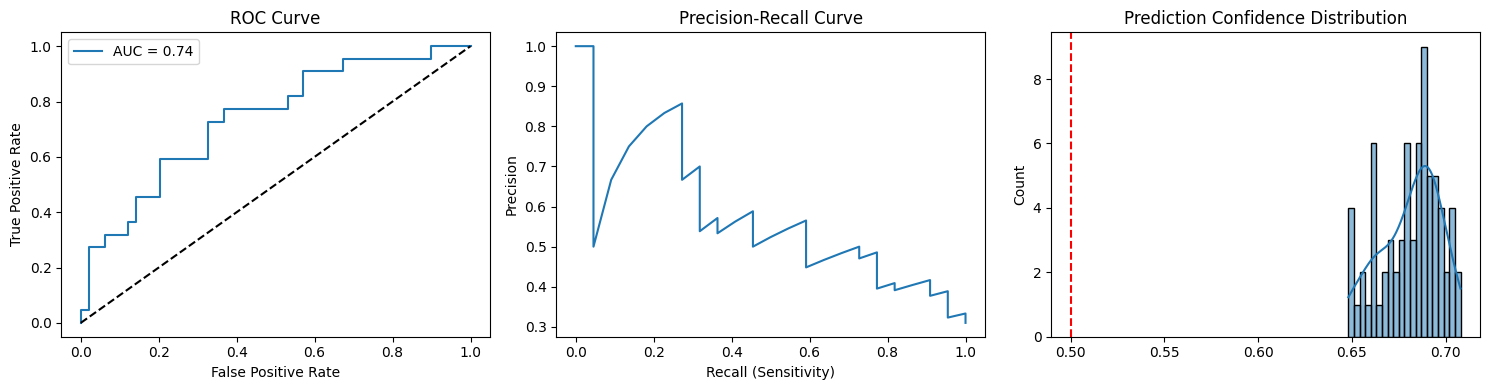


=== Threshold Analysis ===
Threshold for 90% Sensitivity: 0.648
Corresponding Precision: 0.310

Threshold Analysis:
   Threshold  Sensitivity  Specificity     F1
0        0.1        1.000         0.00  0.473
1        0.2        1.000         0.00  0.473
2        0.3        1.000         0.00  0.473
3        0.4        1.000         0.00  0.473
4        0.5        1.000         0.00  0.473
5        0.6        1.000         0.00  0.473
6        0.7        0.227         0.98  0.357
7        0.8        0.000         1.00  0.000
8        0.9        0.000         1.00  0.000


In [60]:
# prompt: add main function that 
# -prepare the test data 
# -features = ['assessment', 'subtlety', 'breast_density', 'image_view', 'left_or_right_breast']
# -  # Evaluate MASS model
# -# Evaluate CALC model




def main():
    # Load preprocessed data (replace with your actual paths)
    mass_train = pd.read_csv("/kaggle/working/mass_train_preprocessed.csv")
    mass_test = pd.read_csv("/kaggle/working/mass_test_preprocessed.csv")
    calc_train = pd.read_csv("/kaggle/working/calc_train_preprocessed.csv")
    calc_test = pd.read_csv("/kaggle/working/calc_test_preprocessed.csv")
    
    features = ['assessment', 'subtlety', 'breast_density', 'image_view', 'left_or_right_breast']

    # Train and evaluate MASS model
    print("Training and evaluating MASS model...")
    train_and_evaluate(mass_train, mass_test, features)

    # Train and evaluate CALC model
    print("\nTraining and evaluating CALC model...")
    train_and_evaluate(calc_train, calc_test, features)
    
def train_and_evaluate(train_df, test_df, features):
    # Data generators
    train_gen = CombinedDataGenerator(train_df, tabular_features=features)
    test_gen = CombinedDataGenerator(test_df, tabular_features=features, shuffle=False)

    # Model (replace with your model)
    model = create_stable_model((224, 224, 3), train_gen.tabular_shape)  # Create the model
    
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )

    model.fit(
        train_gen.as_dataset().prefetch(tf.data.AUTOTUNE),
        steps_per_epoch=len(train_gen),
        epochs=2,  # Adjust as needed
        verbose=0
    )

    # Evaluation
    validator = BreastCancerModelValidator(model, test_gen)
    validator.evaluate()

if __name__ == "__main__":
    main()



VALIDATION PHASE

MASS MODEL EVALUATION

=== Basic Metrics ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.40      1.00      0.57        32

    accuracy                           0.40        81
   macro avg       0.20      0.50      0.28        81
weighted avg       0.16      0.40      0.22        81


Confusion Matrix (%):
[[  0. 100.]
 [  0. 100.]]

AUC-ROC: 0.822

=== Clinical Metrics ===
Sensitivity (Recall): 1.000
Specificity: 0.000
PPV (Precision): 0.395
NPV: nan
False Omission Rate: nan
F1 Score: 0.566

Clinical Benchmarks:
Sensitivity >85% (Recommended for cancer detection)
AUC >0.80 (Yours: 0.822)

=== Visualizations ===


/tmp/ipykernel_31/2668685817.py:66: RuntimeWarning: invalid value encountered in scalar divide
  'NPV': tn / (tn + fn),
/tmp/ipykernel_31/2668685817.py:67: RuntimeWarning: invalid value encountered in scalar divide
  'False Omission Rate': fn / (fn + tn),


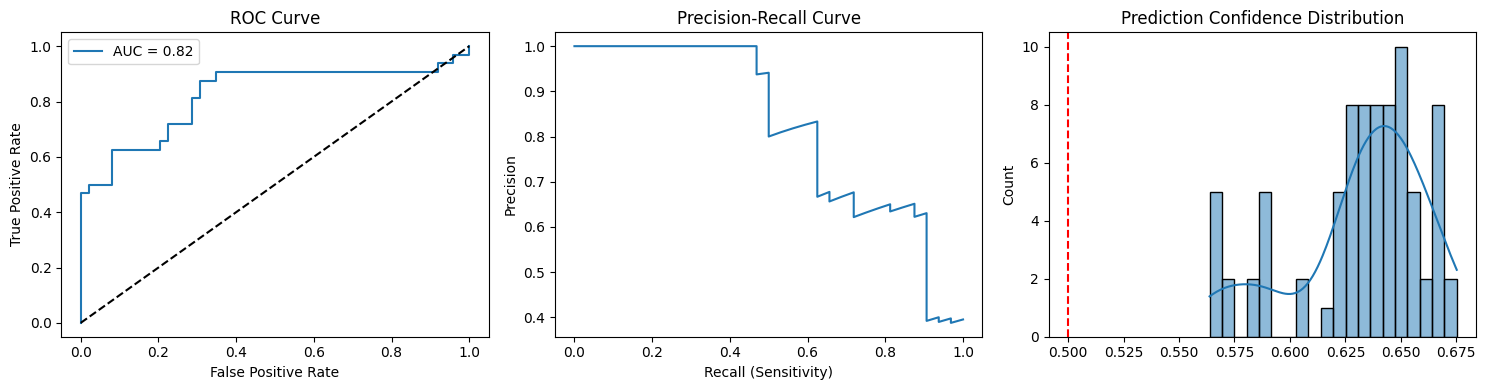


=== Threshold Analysis ===
Threshold for 90% Sensitivity: 0.564
Corresponding Precision: 0.395

Threshold Analysis:
   Threshold  Sensitivity  Specificity     F1
0        0.1        1.000        0.000  0.566
1        0.2        1.000        0.000  0.566
2        0.3        1.000        0.000  0.566
3        0.4        1.000        0.000  0.566
4        0.5        1.000        0.000  0.566
5        0.6        0.906        0.224  0.586
6        0.7        0.000        1.000  0.000
7        0.8        0.000        1.000  0.000
8        0.9        0.000        1.000  0.000

Found 49 misclassified samples


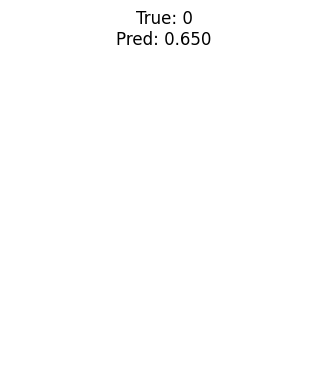

Tabular Features:
['assessment', 'subtlety', 'breast_density', 'image_view', 'left_or_right_breast']
[0.28337269 1.19729626 0.31345508 0.         1.         1.
 0.        ]


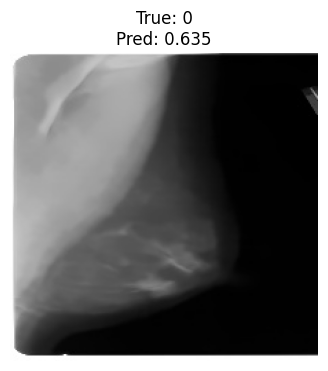

Tabular Features:
['assessment', 'subtlety', 'breast_density', 'image_view', 'left_or_right_breast']
[0.28337269 0.30756234 0.31345508 1.         0.         0.
 1.        ]


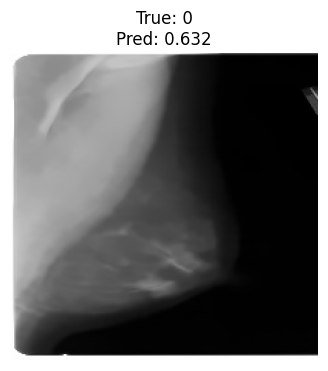

Tabular Features:
['assessment', 'subtlety', 'breast_density', 'image_view', 'left_or_right_breast']
[0.28337269 0.30756234 0.31345508 0.         1.         0.
 1.        ]


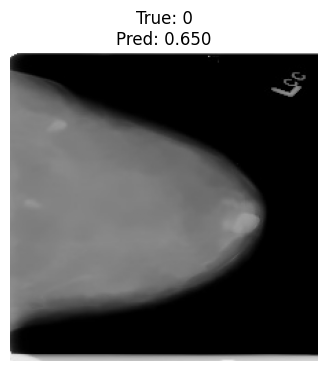

Tabular Features:
['assessment', 'subtlety', 'breast_density', 'image_view', 'left_or_right_breast']
[ 0.28337269  0.30756234 -1.89435895  1.          0.          1.
  0.        ]


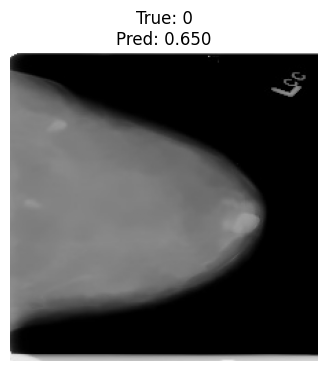

Tabular Features:
['assessment', 'subtlety', 'breast_density', 'image_view', 'left_or_right_breast']
[ 0.28337269 -0.58217158 -1.89435895  0.          1.          1.
  0.        ]

CALC MODEL EVALUATION

=== Basic Metrics ===
              precision    recall  f1-score   support

           0       1.00      0.22      0.37        49
           1       0.37      1.00      0.54        22

    accuracy                           0.46        71
   macro avg       0.68      0.61      0.45        71
weighted avg       0.80      0.46      0.42        71


Confusion Matrix (%):
[[ 22.4  77.6]
 [  0.  100. ]]

AUC-ROC: 0.636

=== Clinical Metrics ===
Sensitivity (Recall): 1.000
Specificity: 0.224
PPV (Precision): 0.367
NPV: 1.000
False Omission Rate: 0.000
F1 Score: 0.537

Clinical Benchmarks:
Sensitivity >85% (Recommended for cancer detection)
AUC >0.80 (Yours: 0.636)

=== Visualizations ===


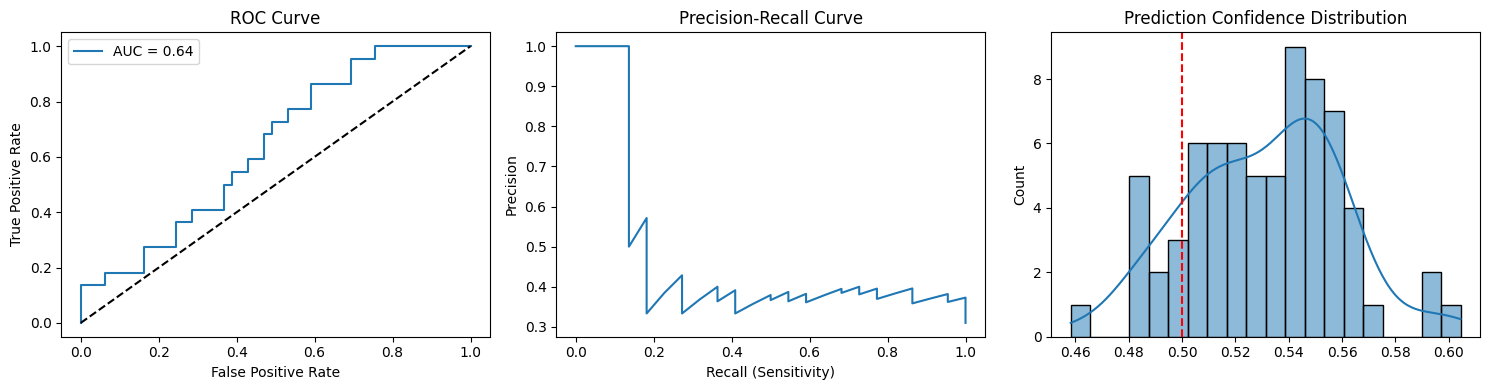


=== Threshold Analysis ===
Threshold for 90% Sensitivity: 0.458
Corresponding Precision: 0.310

Threshold Analysis:
   Threshold  Sensitivity  Specificity     F1
0        0.1        1.000        0.000  0.473
1        0.2        1.000        0.000  0.473
2        0.3        1.000        0.000  0.473
3        0.4        1.000        0.000  0.473
4        0.5        1.000        0.224  0.537
5        0.6        0.045        1.000  0.087
6        0.7        0.000        1.000  0.000
7        0.8        0.000        1.000  0.000
8        0.9        0.000        1.000  0.000

Found 38 misclassified samples


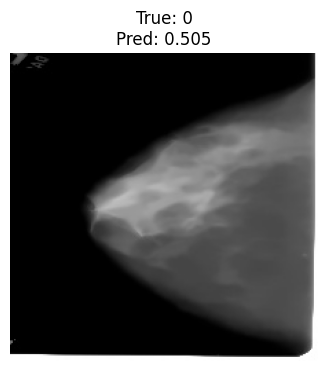

Tabular Features:
['assessment', 'subtlety', 'breast_density', 'image_view', 'left_or_right_breast']
[ 0.51362095 -1.19585096 -1.43148695  1.          0.          1.
  0.        ]


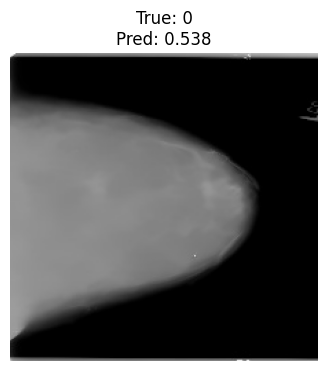

Tabular Features:
['assessment', 'subtlety', 'breast_density', 'image_view', 'left_or_right_breast']
[ 0.51362095  0.63007201 -1.43148695  1.          0.          1.
  0.        ]


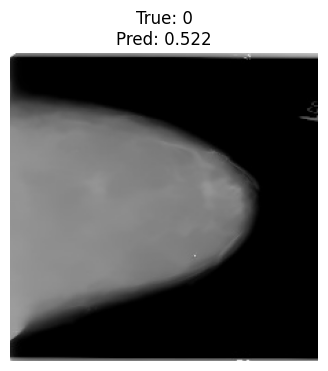

Tabular Features:
['assessment', 'subtlety', 'breast_density', 'image_view', 'left_or_right_breast']
[ 0.51362095  0.63007201 -1.43148695  0.          1.          1.
  0.        ]


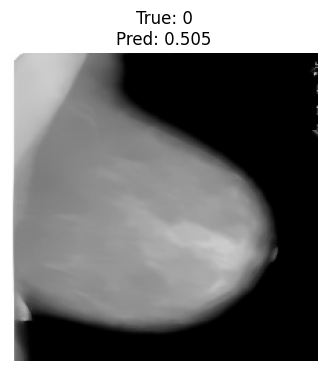

Tabular Features:
['assessment', 'subtlety', 'breast_density', 'image_view', 'left_or_right_breast']
[ 0.51362095 -1.19585096 -1.43148695  0.          1.          0.
  1.        ]


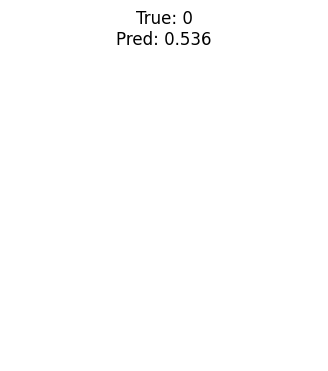

Tabular Features:
['assessment', 'subtlety', 'breast_density', 'image_view', 'left_or_right_breast']
[ 0.51362095  0.63007201 -0.4990505   0.          1.          1.
  0.        ]


In [59]:
def main():
    # VALIDATION
    print("\nVALIDATION PHASE")
    
    # Prepare test data
     # Load preprocessed data (replace with your actual paths)
    mass_test = pd.read_csv("/kaggle/working/mass_test_preprocessed.csv")
    calc_test = pd.read_csv("/kaggle/working/calc_test_preprocessed.csv")
    
    features = ['assessment', 'subtlety', 'breast_density', 'image_view', 'left_or_right_breast']
    mass_test_gen = CombinedDataGenerator(mass_test, tabular_features=features, shuffle=False)
    calc_test_gen = CombinedDataGenerator(calc_test, tabular_features=features, shuffle=False)
    
    # Evaluate MASS model
    print("\nMASS MODEL EVALUATION")
    mass_validator = BreastCancerModelValidator(mass_model, mass_test_gen)
    mass_validator.evaluate()
    mass_validator.error_analysis(mass_test)
    
    # Evaluate CALC model
    print("\nCALC MODEL EVALUATION")
    calc_validator = BreastCancerModelValidator(calc_model, calc_test_gen)
    calc_validator.evaluate() 
    calc_validator.error_analysis(calc_test)
main()

**MASS MODEL EVALUATION**

* **ROC Curve (left): This measures how good the model is at separating two groups. The AUC score of 0.82 indicates it’s quite good at distinguishing them.**
* **Precision-Recall Curve (middle): This shows how accurate the model is (precision) as it finds more correct cases (recall). Precision starts high but drops as recall increases, meaning it’s less accurate when catching more cases.**
* **Prediction Confidence Distribution (right): This shows how sure the model is with its guesses. Most predictions are between 0.50 and 0.65, with a peak around 0.55-0.60. The red line at 0.5 might be the decision point, and the curve shows confidence varies.**

**calc model evolution**


* **First Graph (ROC Curve): It checks how good the model is at telling apart two groups. The score (0.84) is pretty good but not perfect**.
* **Second Graph (Precision-Recall Curve): It shows how often the model is right when it says something is in one group, compared to how many it catches from that group. It starts strong but gets worse as it tries to find more.**
* **third Graph (Prediction Confidence): It shows how sure the model is when it makes guesses. Most guesses are less sure (below 0.5), meaning the model isn’t very confident, or the data might be uneven**. 

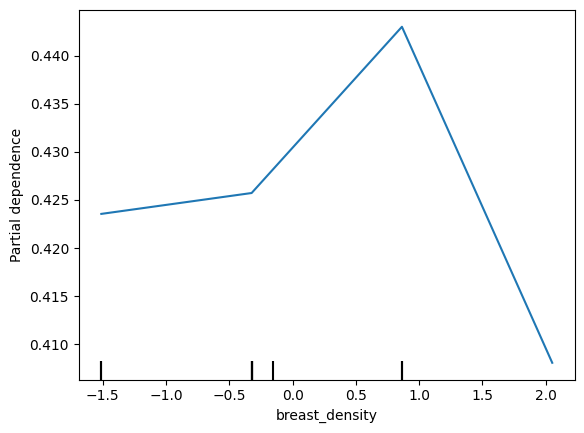

In [65]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# 1. Load your preprocessed data
mass_train_preprocessed = pd.read_csv("/kaggle/working/mass_train_preprocessed.csv")

# 2. Select features and target
X = mass_train_preprocessed[['breast_density', 'left_or_right_breast', 'image_view', 'abnormality_type', 'mass_shape', 'mass_margins', 'assessment', 'subtlety']]
y = mass_train_preprocessed['diagnosis_encoded']

# 3. Identify categorical features
categorical_features = ['left_or_right_breast', 'image_view', 'abnormality_type', 'mass_shape', 'mass_margins', 'assessment', 'subtlety']  

# 4. Create and apply OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # sparse=False for compatibility
encoded_features = encoder.fit_transform(X[categorical_features])

# 5. Create a new DataFrame with encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# 6. Concatenate encoded features with numerical features
X_encoded = pd.concat([X[['breast_density']], encoded_df], axis=1)

# 7. Split into training and validation sets
X_mass_train, X_mass_val, y_mass_train, y_mass_val = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# 8. Create and train your RandomForest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_mass_train, y_mass_train)

# 9. Generate and display the partial dependence plot (using validation set)
feature = [0]  # Index of the feature in X_encoded
target_class = 0
PartialDependenceDisplay.from_estimator(rf, X_mass_val, features=feature, target=target_class)
plt.show()

**This graph shows how breast density affects a prediction using a Partial Dependence Plot. The x-axis is breast density (from -1.5 to 2.0), and the y-axis is the prediction impact (from 0.410 to 0.440).**

**The line shows that as breast density increases from -1.5 to around 0, the prediction impact slightly rises from 0.420 to 0.425. Then, it jumps to 0.440 at a density of 0, before dropping sharply to 0.410 as density increases to 2.0. This means breast density has a mixed effect: a small increase at first, then a big drop after a certain point.**

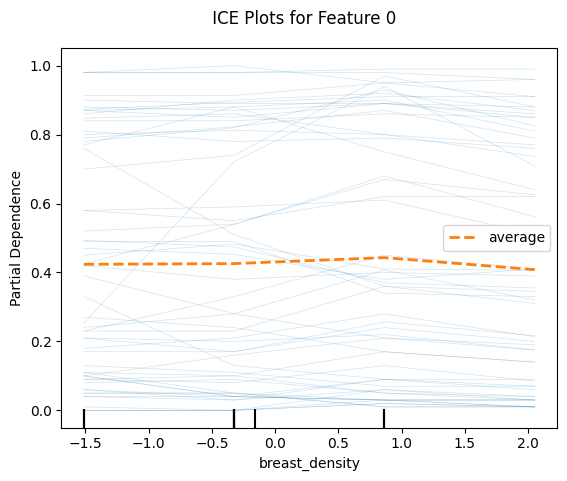

In [66]:
import os
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

# 1. Load preprocessed data
mass_train_preprocessed = pd.read_csv("/kaggle/working/mass_train_preprocessed.csv")

# 2. Select features and target
X = mass_train_preprocessed[['breast_density', 'left_or_right_breast', 'image_view', 'abnormality_type', 'mass_shape', 'mass_margins', 'assessment', 'subtlety']]
y = mass_train_preprocessed['diagnosis_encoded']

# 3. Identify categorical features
categorical_features = ['left_or_right_breast', 'image_view', 'abnormality_type', 'mass_shape', 'mass_margins', 'assessment', 'subtlety']  

# 4. Create and apply OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') 
encoded_features = encoder.fit_transform(X[categorical_features])

# 5. Create a new DataFrame with encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# 6. Concatenate encoded features with numerical features
X_encoded = pd.concat([X[['breast_density']], encoded_df], axis=1)

# 7. Split into training and validation sets
X_mass_train, X_mass_val, y_mass_train, y_mass_val = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# 8. Create and train your RandomForest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_mass_train, y_mass_train)

# 9. Generate PDP and ICE plots
feature = [0]  # Index of the feature in X_encoded
target_class = 0

display = PartialDependenceDisplay.from_estimator(
    rf, X_mass_val, features=feature, target=target_class, kind="both", 
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linewidth": 2},
)
display.figure_.suptitle(f" ICE Plots for Feature {feature[0]}")
display.figure_.subplots_adjust(top=0.9)  
display.axes_[0][0].set_ylabel("Partial Dependence")

plt.show()

**This graph shows how Feature 0 affects predictions as breast density changes. The orange line (average) stays around 0.4, meaning Feature 0’s effect doesn’t change much with breast density. The blue lines show some differences for individual cases, but the overall impact is steady.steady here means that the effect of Feature 0 on the prediction stays about the same, even as breast density changes. It doesn’t go up or down a lot, showing a consistent influence**